In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14


In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision.transforms import v2


In [4]:
from pymono.cnns import x_cnn_evaluation, x_single_run, x_train_cnn
from pymono.cnns import Conv2dPars,  MaxPool2dPars,  LinealLayerPars
from pymono.cnns import build_conv_layer, build_conv_layers, build_linear_layers
from pymono.cnns import xCNN, xResNet10, xResNet8, ResBlock

In [5]:
from pymono.plt_funcs import  plot_loss, plot_accuracy, cifar_plot_image_and_label 
from pymono.plt_funcs import  plot_energies2, histoplot, plotxyz, plot_dataset
from pymono.cnn_plots import plot_images2, plot_images2c
from pymono.cnn_plots import plot2c_z, plot_images_and_labels, plot_images_and_positions

In [6]:
from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata
from pymono.cnn_aux import get_energy2, get_means_stds2

In [7]:
from pymono.xdataset import XDataset, RDataset, R2Dataset
from pymono.mono_dl import mono_data_loader
from pymono.cnn_eval import evaluate_cnn, evaluate_2c_cnn, cnn_xeval, single_run, train_cnn

In [8]:
from pymono.cnn_func import CNN_basic
from pymono.cnn_func import  CNN

In [9]:
from pymono.cnn_eval import cnn_evaluation 

In [10]:
from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Local functions

In [12]:
def print_features(train_loader):
    train_features, train_labels = next(iter(train_loader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

In [143]:
tdeltas = namedtuple('tdeltas','delta_x_NN, delta_y_NN, delta_z_NN')

## Voxelization at 12 mm
- df1c is the directory containing images and labels for events classified as single cluster (1c)
- df2c is the directory containing images and labels for events classified as double cluster (2c)
- dfnc is the directory containing images and labels for events classified as multiple cluster (nc)
- Files are in format1:
    - images files are of the form: images_n.npy, where n is a number.
    - labels are stored in a single file (labels.csv)
 
- Data corresponds to CsITl (50 k MeV rather than 100 k /MeV)

In [16]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")

In [17]:
img_names, csv_name = get_file_names_format1(d1c)

In [18]:
img_names[0]

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/df1c/images_1.npy'

In [19]:
csv_name

['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/df1c/df1c_12mm.csv']

### Label data
- When sorted by value, label data corresponds to the image stored in the directory.
- event_id = 10000 x image_number, so that event 1004 corresponds to the fourth image in file images_1.npy

In [20]:
df1c = pd.read_csv(csv_name[0])
df1c.head(10)

,event_id,e,x,y,z,t
0,1920001,0.510288,-19.789452,8.305963,1.720408,0.069315
1,1920004,0.509489,-2.209223,-7.694947,3.177913,0.073910
2,1920005,0.509517,-8.763308,-7.670571,22.246649,0.135776
3,1920009,0.509501,7.650528,2.669027,33.027400,0.171835
4,1920012,0.510023,19.462490,-13.702425,15.004047,0.125795
5,1920014,0.510347,22.622807,23.873697,6.112050,0.081390
6,1920017,0.510870,-18.403818,6.687153,13.607588,0.106872
7,1920019,0.510061,9.387810,-17.355295,19.114010,0.126660
8,1920021,0.509503,-7.090213,-16.762836,17.058360,0.119935
9,1920031,0.507575,-5.262087,-19.196625,19.081472,0.125530


#### Example
- Images and labels in first file of directory

In [21]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

df1cs = get_img_file_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")


image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/df1c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 3049
number of labels in file = 3049


In [22]:
df1cs.head(10)

,event_id,e,x,y,z,t
144550,10006,0.509922,-11.797090,-18.706337,19.845798,0.128977
144551,10013,0.508865,-5.694461,-15.383989,1.317396,0.067932
144552,10014,0.510058,-12.474124,-23.824984,6.198423,0.081103
144553,10016,0.510171,21.307316,19.975979,5.213755,0.080465
144554,10017,0.509717,-19.122648,20.913584,35.491890,0.179873
144555,10026,0.507920,11.565461,-7.917347,10.502496,0.097198
144556,10027,0.509717,-16.532148,9.670679,33.228730,0.172357
144557,10028,0.507915,2.573587,-15.676525,35.443943,0.179403
144558,10031,0.510007,-2.871538,3.663483,28.352789,0.158213
144559,10033,0.509915,21.300068,-14.392266,15.292956,0.114090


In [23]:
df1cs.values[0]

array([ 1.0006000e+04,  5.0992167e-01, -1.1797090e+01, -1.8706337e+01,
        1.9845798e+01,  1.2897693e-01])

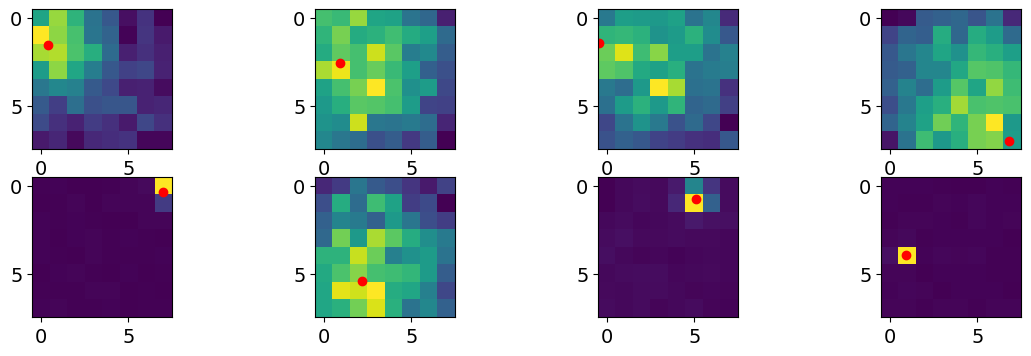

In [24]:
plot_images2(imgs, df1cs, (0,8), pixel_size = 6, grid_size=8)

In [25]:
energy = get_energy2(imgs)

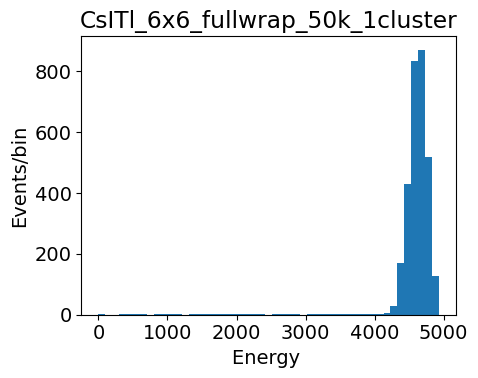

In [27]:
plot_energies2({"CsITl_6x6_fullwrap_50k_1cluster":energy}, xmin=0, xmax=max(energy),num_bins = 50)

# Regression Studies

### Load data
- Use RDataset which stores (images, (x,y,z)).
- No normalization.
- No previous classification

In [28]:
first_file = 0  # initial file indx
last_file  = 200  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [29]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=False)  

Running rDataset with norm = False
Loading files in directory d1c with indexes: 0, 200
   event_id         e          x          y          z         t
0   1920001  0.510288 -19.789452   8.305963   1.720408  0.069315
1   1920004  0.509489  -2.209223  -7.694947   3.177913  0.073910
2   1920005  0.509517  -8.763308  -7.670571  22.246649  0.135776
3   1920009  0.509501   7.650528   2.669027  33.027400  0.171835
4   1920012  0.510023  19.462490 -13.702425  15.004047  0.125795
5   1920014  0.510347  22.622807  23.873697   6.112050  0.081390
6   1920017  0.510870 -18.403818   6.687153  13.607588  0.106872
7   1920019  0.510061   9.387810 -17.355295  19.114010  0.126660
8   1920021  0.509503  -7.090213 -16.762836  17.058360  0.119935
9   1920031  0.507575  -5.262087 -19.196625  19.081472  0.125530
image name = images_1.npy
image number = 1
number of images in file = 3049
number of labels in file = 3049
meta =>[ 1.0006000e+04  5.0992167e-01 -1.1797090e+01 -1.8706337e+01
  1.9845798e+01  1.2897

In [30]:
dataset[3]

(tensor([[[ 27.,  29.,  52.,  54.,  56.,  50.,  60.,  37.],
          [ 45.,  55.,  53.,  81.,  56.,  81.,  75.,  57.],
          [ 51.,  61.,  67.,  78.,  71.,  85.,  82.,  76.],
          [ 52.,  54.,  67.,  67.,  79.,  91.,  90.,  85.],
          [ 54.,  66.,  58.,  75.,  91.,  78., 100.,  87.],
          [ 48.,  62.,  76.,  82., 102.,  89.,  90.,  89.],
          [ 55.,  66.,  77.,  95.,  84.,  96., 114.,  74.],
          [ 32.,  60.,  87.,  74.,  82.,  96.,  98.,  75.]]]),
 tensor([21.3073, 19.9760,  5.2138]))

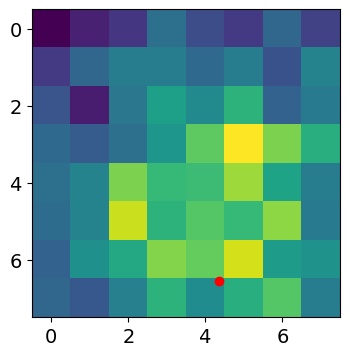

In [31]:
plot_dataset(dataset[15], pixel_size = 6, grid_size=8)

In [32]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 614775 events
 train size = 430342
 val size = 122955
 test size = 61478
 train indices = range(0, 430342)
 val indices = range(430342, 553297)
 test indices = range(553297, 614775)
430342 training events (69.9999186694319%)
122955 validation events (20.0%)
61478 test events (10.000081330568094%)


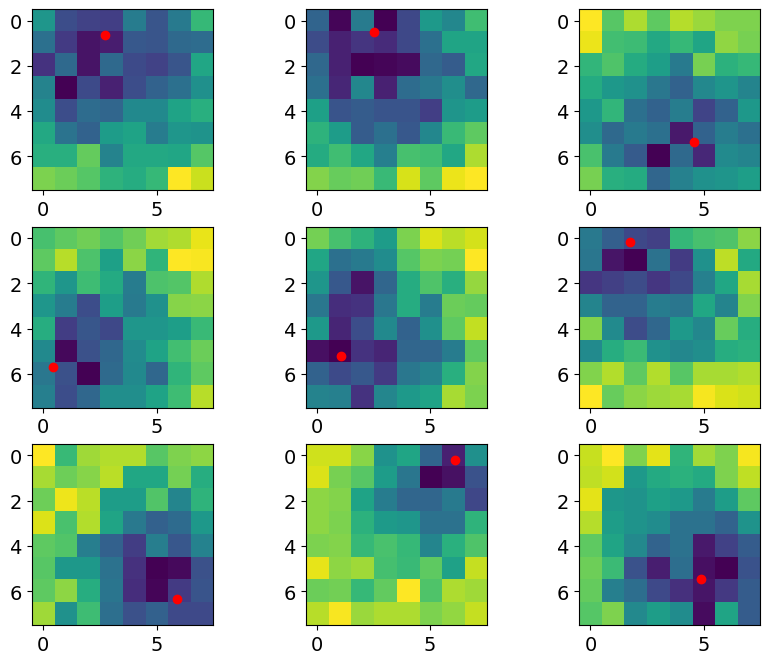

In [33]:
plot_images_and_positions(train_loader, start=0, figsize=(10, 8))

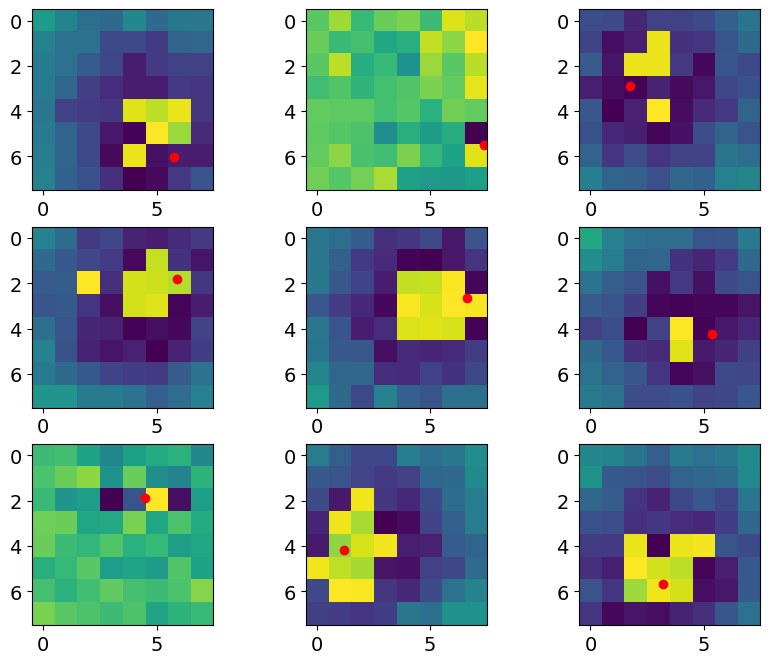

In [30]:
plot_images_and_positions(train_loader, start=10, figsize=(10, 8))

## Compare different CNNs

In [34]:
def build_cnn_l4k3322_conv_layers():
    CL = []
    c1 = Conv2dPars(in_channels=1, out_channels=64, kernel_size=3, padding=1)
    c2 = Conv2dPars(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    c3 = Conv2dPars(in_channels=128, out_channels=256, kernel_size=2, padding=1)
    c4 = Conv2dPars(in_channels=256, out_channels=512, kernel_size=2, padding=1)
    p2d = MaxPool2dPars(kernel_size=2, stride=2)
    CL.append(build_conv_layer(c1, p2d, relu='leaky'))
    CL.append(build_conv_layer(c2, p2d, relu='leaky'))
    CL.append(build_conv_layer(c3, p2d, relu='leaky'))
    CL.append(build_conv_layer(c4, p2d, relu='leaky'))
    return CL, build_conv_layers(CL)

In [35]:
def build_cnn_ll(inl=512, out=3, dropout_fraction=0.25):
    LLYR=[]
    LLYR.append(LinealLayerPars(inl,256))
    LLYR.append(LinealLayerPars(256, 128))
    #LLYR.append(LinealLayerPars(128, 2))
    LLYR.append(LinealLayerPars(128, out))
    return build_linear_layers(LLYR, df=dropout_fraction)

In [36]:
CL, clyrs = build_cnn_l4k3322_conv_layers()

In [37]:
x_cnn_evaluation(torch.randn(1,1,8,8), CL)

shape of input image = torch.Size([1, 1, 8, 8])
 after cl = 1, shape of out image = torch.Size([1, 64, 4, 4])
 after cl = 2, shape of out image = torch.Size([1, 128, 2, 2])
 after cl = 3, shape of out image = torch.Size([1, 256, 1, 1])
 after cl = 4, shape of out image = torch.Size([1, 512, 1, 1])
shape of flattened image = torch.Size([1, 512])


In [38]:
llyrs =  build_cnn_ll(inl=512, out=3,dropout_fraction=0.25)

In [39]:
llyrs2 = build_cnn_ll(inl=512, out=6,dropout_fraction=0.25)

In [40]:
llyrsx = build_cnn_ll(inl=512, out=2,dropout_fraction=0.25)

In [41]:
model = xCNN(clyrs,llyrs).to(device)

In [42]:
model2 = xCNN(clyrs,llyrs2).to(device)

In [43]:
modelx = xCNN(clyrs,llyrsx).to(device)

In [44]:
print(model)

xCNN(
  (conv_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [45]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
         LeakyReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
         LeakyReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
        LeakyReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [46]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [47]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=15, iprnt=100)

Training with  ->430400 images
size of train loader  ->4304 images
Evaluating with  ->123000 images
size of eval loader  ->1230 images
Running for epochs ->15

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 10.60760094884603
--- EPOCH 0 AVG VAL LOSS: 7.695293818838228

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 7.614574821908235
--- EPOCH 1 AVG VAL LOSS: 6.490992525147229

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.09976961067618
--- EPOCH 2 AVG VAL LOSS: 6.408755353020458

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.787291820109112
--- EPOCH 3 AVG VAL LOSS: 6.019772392753663

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.629272575715217
--- EPOCH 4 AVG VAL LOSS: 5.941944874592913

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.504464396646032
--- EPOCH 5 AVG VAL LOSS: 6.140583991035213

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 6.394946234764663
--- EPOCH 6 AVG VAL LOSS: 5.8431672809569815

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 6.318893605171526
--- EPOCH 7 AVG VAL LOSS: 5.958515489392164

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 6.2115198892

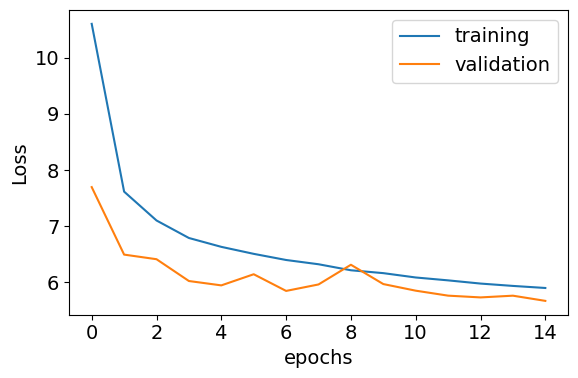

In [48]:
plot_loss(15, train_losses, val_losses,figsize=(6, 4))

In [49]:
tdeltas = evaluate_cnn(test_loader, model, device)

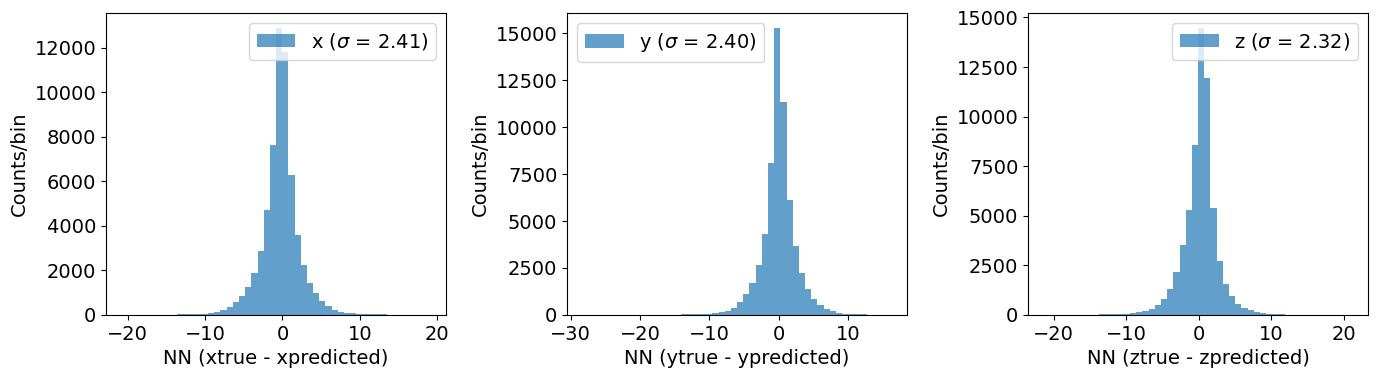

In [50]:
plotxyz(tdeltas, nbins=50)

In [51]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = 0.02, sigma = 2.31, n1  =0.37
2g fit: mu2 = 0.59, sigma = 0.70, n1  =0.63
weighted error: = 1.30
2g fit: mu1 = -0.12, sigma = 0.72, n1  =0.63
2g fit: mu2 = -0.30, sigma = 2.48, n1  =0.37
weighted error: = 1.37
2g fit: mu1 = 0.10, sigma = 2.46, n1  =0.37
2g fit: mu2 = -0.05, sigma = 0.67, n1  =0.63
weighted error: = 1.33


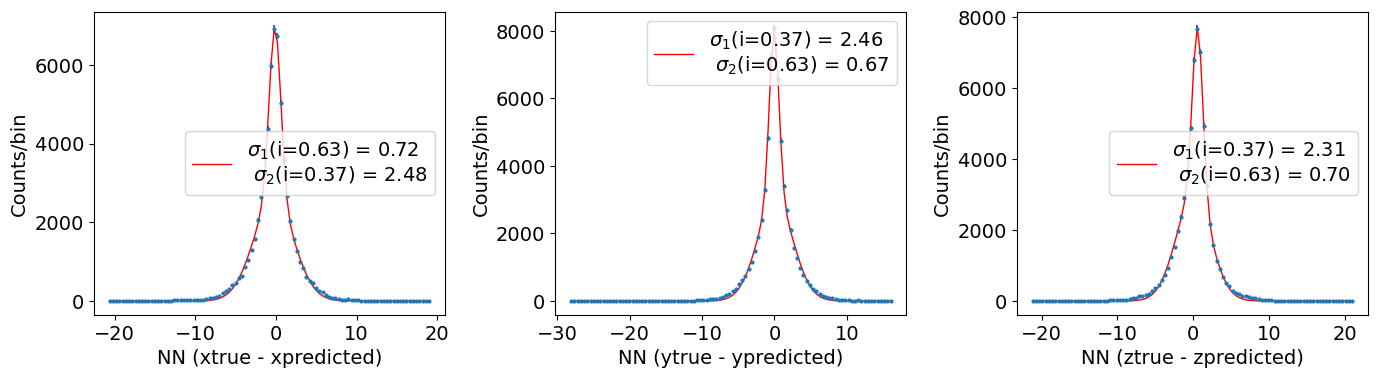

In [52]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [53]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)

In [54]:
print(model)

CNN_basic(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [55]:
summary(model,(1,8,8))

input data shape =>torch.Size([2, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([2, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([2, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([2, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([2, 512])
torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 8, 8]           1,280
       BatchNorm2d-2            [-1, 128, 8, 8]             256
         MaxPool2d-3            [-1, 128, 4, 4]               0
            Conv2d-4            [-1, 256, 5, 5]         131,328
       BatchNorm2d-5            [-1, 256, 5, 5]             512
         MaxPool2d-6            [-1, 256, 2, 2]               0
            Conv2d-7            [-1, 512, 3, 3]         524,800
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
         MaxPool2d-9            [-1, 512, 1, 1]               0
           Linear-10              

In [56]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [57]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=15, iprnt=100)

Training with  ->430400 images
size of train loader  ->4304 images
Evaluating with  ->123000 images
size of eval loader  ->1230 images
Running for epochs ->15

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 8.979804672937854
--- EPOCH 0 AVG VAL LOSS: 7.515096273654844

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 7.1432087888948095
--- EPOCH 1 AVG VAL LOSS: 6.556516646563522

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 6.724457491507761
--- EPOCH 2 AVG VAL LOSS: 6.514028922135267

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.52452079176238
--- EPOCH 3 AVG VAL LOSS: 6.245579264803631

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.3839769920673515
--- EPOCH 4 AVG VAL LOSS: 6.166987297205421

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.285334866673973
--- EPOCH 5 AVG VAL LOSS: 6.330783155293969

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 6.199905092665254
--- EPOCH 6 AVG VAL LOSS: 6.369152179966128

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 6.12969727736645
--- EPOCH 7 AVG VAL LOSS: 6.229085708052162

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 6.0788759672

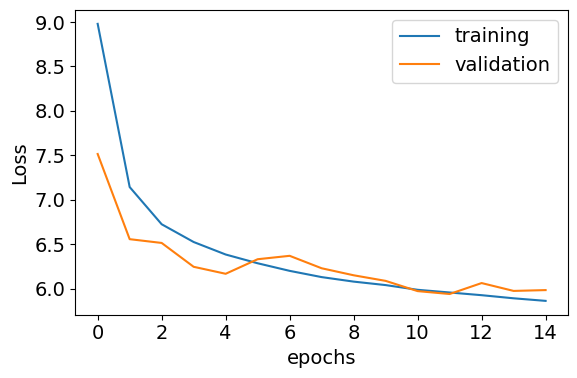

In [58]:
plot_loss(15, train_losses, val_losses,figsize=(6, 4))

In [59]:
tdeltas = evaluate_cnn(test_loader, model, device)

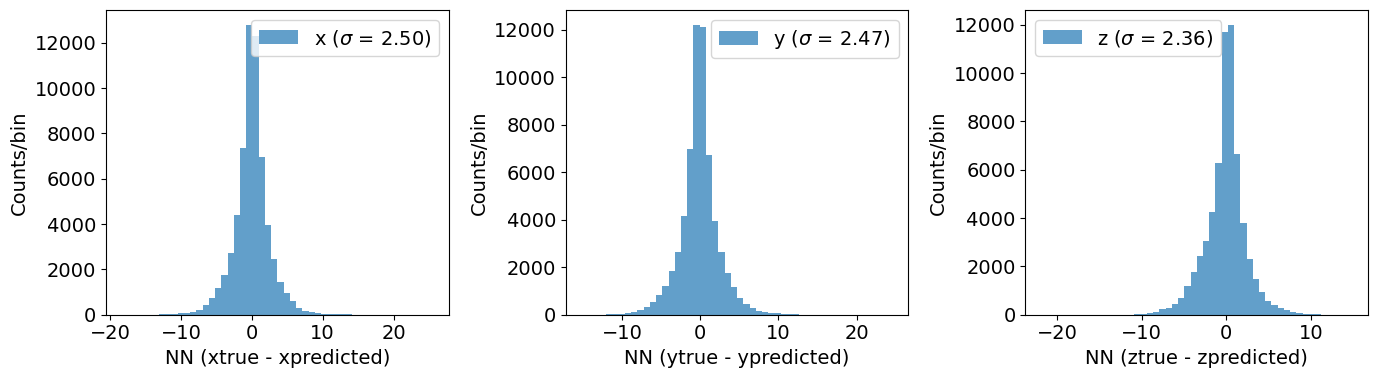

In [60]:
plotxyz(tdeltas, nbins=50)

In [61]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = 0.24, sigma = 0.65, n1  =0.65
2g fit: mu2 = -0.20, sigma = 2.57, n1  =0.35
weighted error: = 1.32
2g fit: mu1 = 0.06, sigma = 0.76, n1  =0.60
2g fit: mu2 = -0.05, sigma = 2.58, n1  =0.40
weighted error: = 1.48
2g fit: mu1 = -0.10, sigma = 0.72, n1  =0.64
2g fit: mu2 = -0.13, sigma = 2.62, n1  =0.36
weighted error: = 1.40


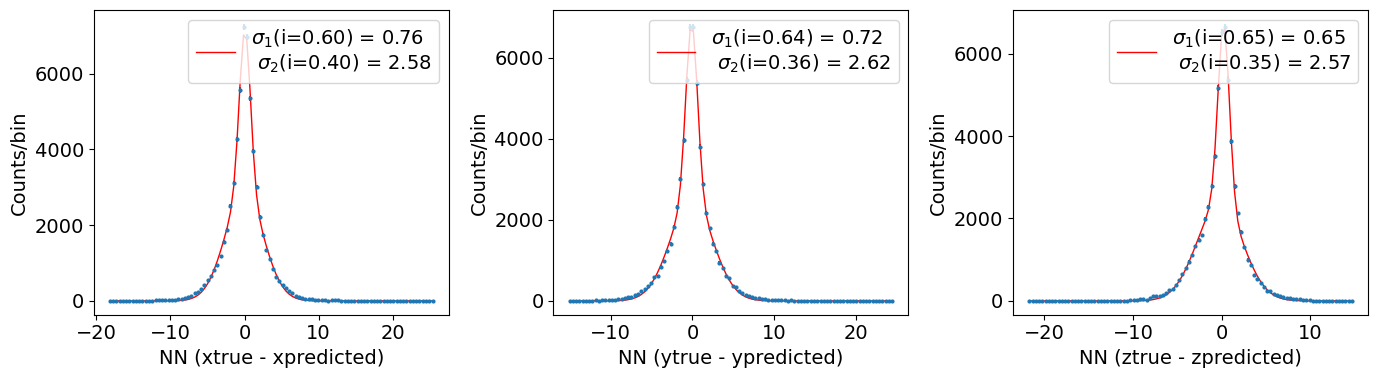

In [62]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

### Resnet

In [63]:
model = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 3, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [64]:
summary(model,(1,8,8))

  ResNet8: input data shape =>torch.Size([2, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([2, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([2, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([2, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([2, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([2, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([2, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([2, 512])
  ResNet8: after fc =>torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7       

In [65]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [66]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=15, iprnt=100)

Training with  ->430400 images
size of train loader  ->4304 images
Evaluating with  ->123000 images
size of eval loader  ->1230 images
Running for epochs ->15

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 9.513731788414562
--- EPOCH 0 AVG VAL LOSS: 6.836128343023905

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 7.479466551852492
--- EPOCH 1 AVG VAL LOSS: 6.488257307347244

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.077054851117187
--- EPOCH 2 AVG VAL LOSS: 6.050866148723819

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.844706834581261
--- EPOCH 3 AVG VAL LOSS: 5.999046125063082

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.6936448502828645
--- EPOCH 4 AVG VAL LOSS: 5.760314882480032

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.5788173203574685
--- EPOCH 5 AVG VAL LOSS: 5.989249915029944

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 6.498512978170441
--- EPOCH 6 AVG VAL LOSS: 6.035028522382907

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 6.431312593164054
--- EPOCH 7 AVG VAL LOSS: 5.965149552841496

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 6.36353599

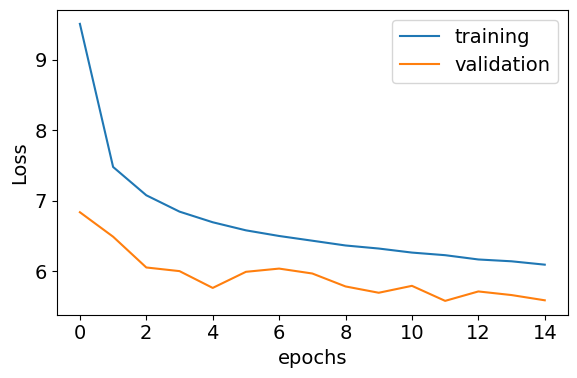

In [68]:
plot_loss(15, train_losses, val_losses,figsize=(6, 4))

In [69]:
tdeltas = evaluate_cnn(test_loader, model, device)

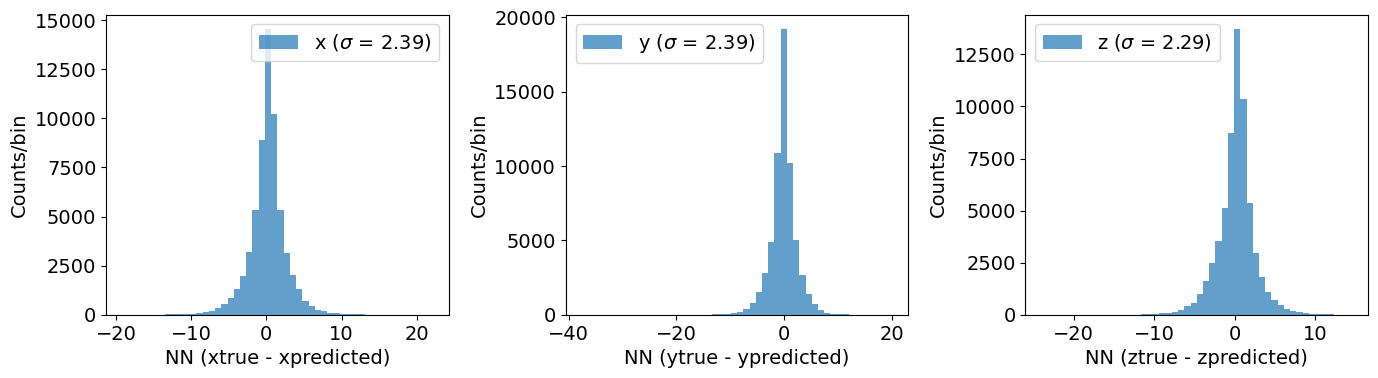

In [70]:
plotxyz(tdeltas, nbins=50)

In [71]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = 0.43, sigma = 0.69, n1  =0.64
2g fit: mu2 = 0.05, sigma = 2.42, n1  =0.36
weighted error: = 1.31
2g fit: mu1 = 0.18, sigma = 2.35, n1  =0.39
2g fit: mu2 = 0.34, sigma = 0.64, n1  =0.61
weighted error: = 1.31
2g fit: mu1 = -0.13, sigma = 0.67, n1  =0.61
2g fit: mu2 = -0.00, sigma = 2.44, n1  =0.39
weighted error: = 1.36


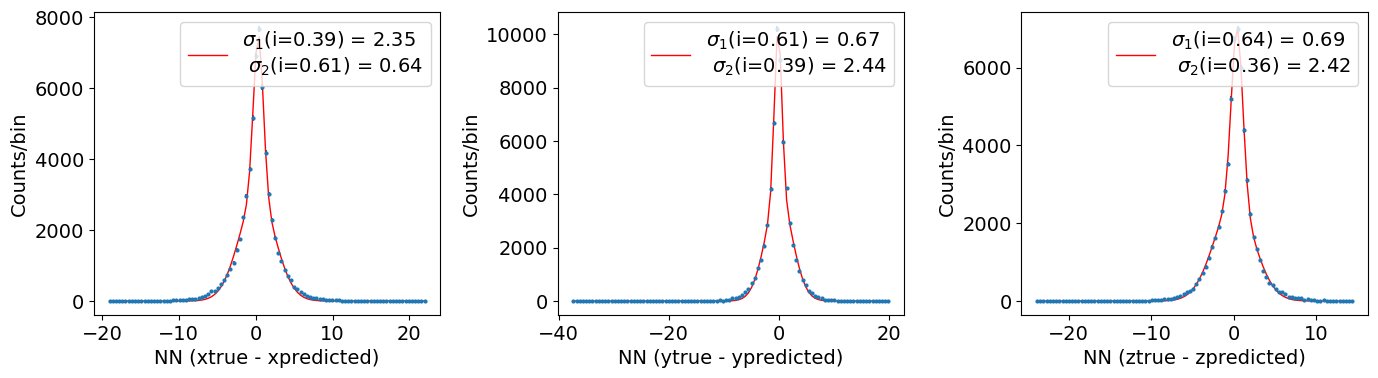

In [72]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## CNN comparison- Weighted error:
- Resnet:(1.37, 1.29, 1.33)
- Basic: (1.44, 1.33, 1.27)
- Dense: (1.32, 1.29, 1.37)

## Normalization

files in dir: 200
shape -> (3102, 8, 8)
mean img0 =74.140625
std  img0 =87.57744598388672


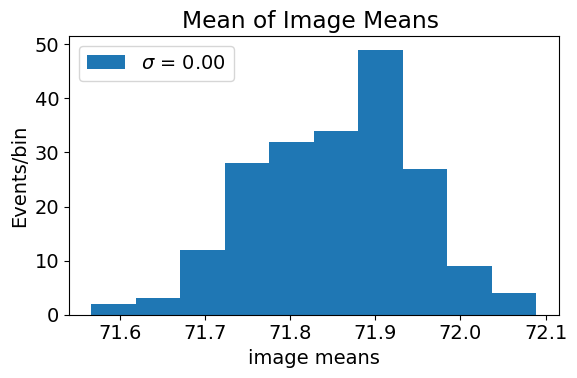

In [73]:
means, stds = get_means_stds2(dir=d1c)
meansx =[np.mean(x) for x in means]
imean = np.mean(meansx)
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))


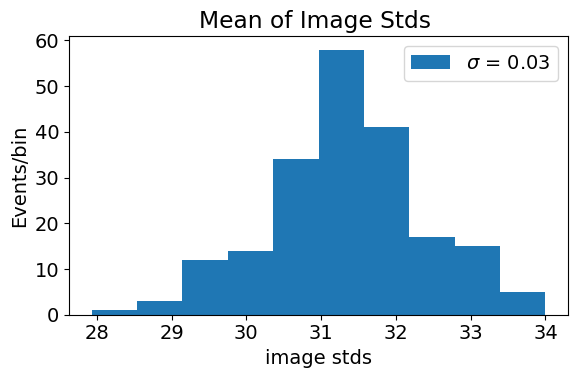

In [74]:
stdsx =[np.std(x) for x in stds]
isigma = np.mean(stdsx)
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))


In [75]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 71.85580444335938, std = 31.351606369018555


In [76]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=True, mean=imean, std=isigma)  

Running rDataset with norm = True
Loading files in directory d1c with indexes: 0, 200
   event_id         e          x          y          z         t
0   1920001  0.510288 -19.789452   8.305963   1.720408  0.069315
1   1920004  0.509489  -2.209223  -7.694947   3.177913  0.073910
2   1920005  0.509517  -8.763308  -7.670571  22.246649  0.135776
3   1920009  0.509501   7.650528   2.669027  33.027400  0.171835
4   1920012  0.510023  19.462490 -13.702425  15.004047  0.125795
5   1920014  0.510347  22.622807  23.873697   6.112050  0.081390
6   1920017  0.510870 -18.403818   6.687153  13.607588  0.106872
7   1920019  0.510061   9.387810 -17.355295  19.114010  0.126660
8   1920021  0.509503  -7.090213 -16.762836  17.058360  0.119935
9   1920031  0.507575  -5.262087 -19.196625  19.081472  0.125530
image name = images_1.npy
image number = 1
number of images in file = 3049
number of labels in file = 3049
meta =>[ 1.0006000e+04  5.0992167e-01 -1.1797090e+01 -1.8706337e+01
  1.9845798e+01  1.28976

In [77]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 614775 events
 train size = 430342
 val size = 122955
 test size = 61478
 train indices = range(0, 430342)
 val indices = range(430342, 553297)
 test indices = range(553297, 614775)
430342 training events (69.9999186694319%)
122955 validation events (20.0%)
61478 test events (10.000081330568094%)


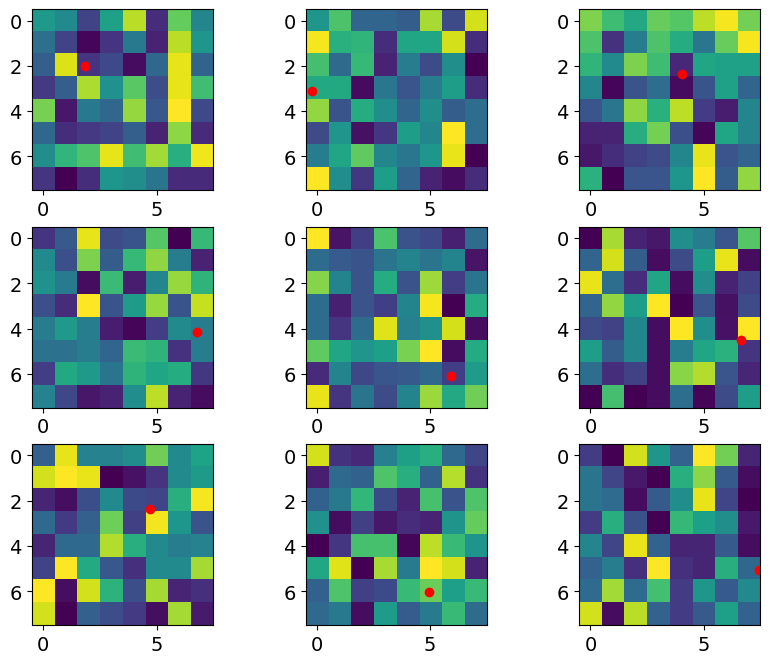

In [78]:
plot_images_and_positions(train_loader, start=0, figsize=(10, 8))

In [79]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [80]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=15, iprnt=100)

Training with  ->430400 images
size of train loader  ->4304 images
Evaluating with  ->123000 images
size of eval loader  ->1230 images
Running for epochs ->15

EPOCH 0
input data shape =>torch.Size([100, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([100, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([100, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([100, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([100, 512])
torch.Size([100, 3])
--- EPOCH 0 AVG TRAIN LOSS: 8.61428117319997
--- EPOCH 0 AVG VAL LOSS: 7.149690956022681

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 6.962319572009561
--- EPOCH 1 AVG VAL LOSS: 6.558239338068458

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 6.612264114352407
--- EPOCH 2 AVG VAL LOSS: 6.516997609875067

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.381554132832914
--- EPOCH 3 AVG VAL LOSS: 6.375998891659869

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.2516562609092015
--- EPOCH 4 AVG VAL LOSS: 6.065640600328523

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.150422989325009
--- EPOCH 5 AVG VA

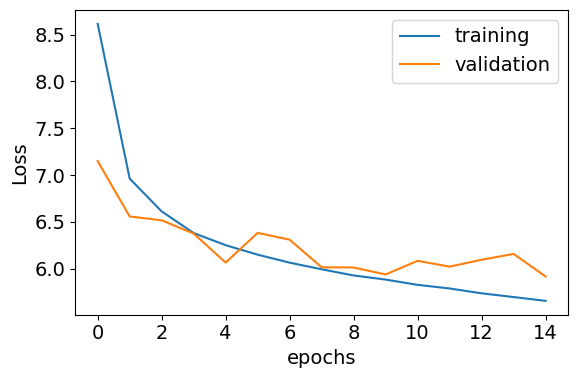

In [81]:
plot_loss(15, train_losses, val_losses,figsize=(6, 4))

In [82]:
tdeltas = evaluate_cnn(test_loader, model, device)

2g fit: mu1 = 0.54, sigma = 0.67, n1  =0.64
2g fit: mu2 = 0.11, sigma = 2.50, n1  =0.36
weighted error: = 1.33
2g fit: mu1 = 0.30, sigma = 2.52, n1  =0.39
2g fit: mu2 = 0.27, sigma = 0.70, n1  =0.61
weighted error: = 1.40
2g fit: mu1 = 0.18, sigma = 2.52, n1  =0.37
2g fit: mu2 = -0.15, sigma = 0.68, n1  =0.63
weighted error: = 1.36


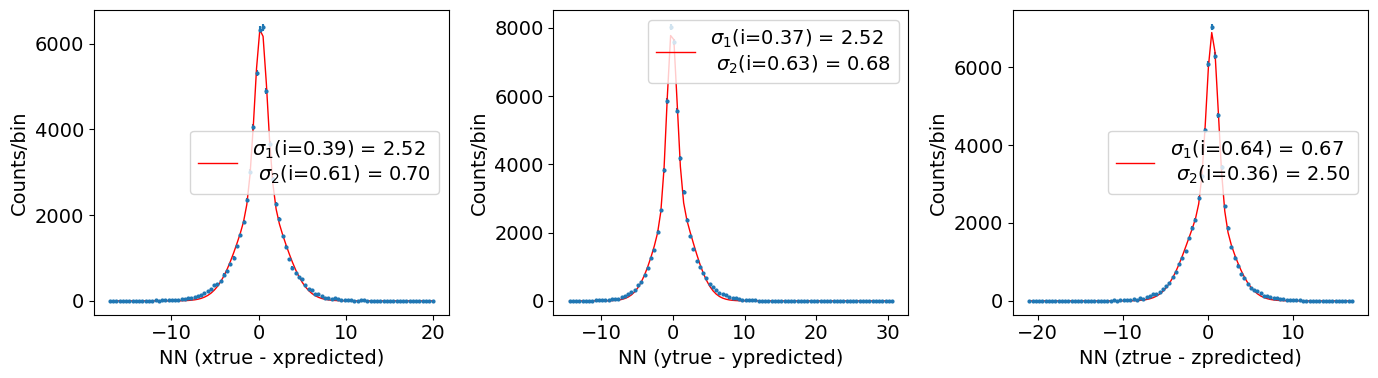

In [83]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [84]:
model = xCNN(clyrs,llyrs).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [85]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=15, iprnt=100)

Training with  ->430400 images
size of train loader  ->4304 images
Evaluating with  ->123000 images
size of eval loader  ->1230 images
Running for epochs ->15

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 6.410125983802803
--- EPOCH 0 AVG VAL LOSS: 6.01162967100376

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 6.131521335709494
--- EPOCH 1 AVG VAL LOSS: 5.870158750254934

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 6.0218382948060905
--- EPOCH 2 AVG VAL LOSS: 5.853831517405626

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 5.967510560852888
--- EPOCH 3 AVG VAL LOSS: 6.102054051461258

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 5.927673015618856
--- EPOCH 4 AVG VAL LOSS: 6.356851375006078

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 5.87955259318467
--- EPOCH 5 AVG VAL LOSS: 5.72643556730534

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 5.863846243757298
--- EPOCH 6 AVG VAL LOSS: 5.879050602563997

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 5.819648289713718
--- EPOCH 7 AVG VAL LOSS: 5.714796770685087

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 5.792687530965

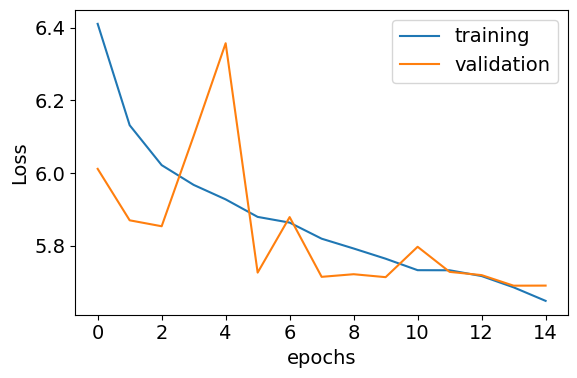

In [86]:
plot_loss(15, train_losses, val_losses,figsize=(6, 4))

2g fit: mu1 = 0.73, sigma = 0.69, n1  =0.63
2g fit: mu2 = 0.10, sigma = 2.41, n1  =0.37
weighted error: = 1.33
2g fit: mu1 = -0.18, sigma = 0.68, n1  =0.61
2g fit: mu2 = -0.01, sigma = 2.44, n1  =0.39
weighted error: = 1.36
2g fit: mu1 = 0.04, sigma = 0.85, n1  =0.66
2g fit: mu2 = -0.09, sigma = 2.66, n1  =0.34
weighted error: = 1.47


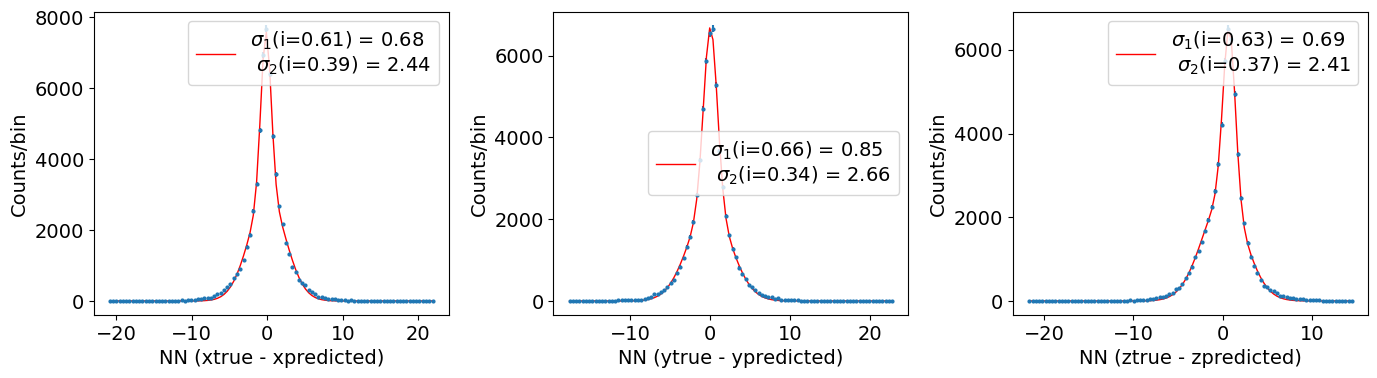

In [87]:
tdeltas = evaluate_cnn(test_loader, model, device)
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [88]:
model = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 3, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [89]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=15, iprnt=100)

Training with  ->430400 images
size of train loader  ->4304 images
Evaluating with  ->123000 images
size of eval loader  ->1230 images
Running for epochs ->15

EPOCH 0
  ResNet8: input data shape =>torch.Size([100, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([100, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([100, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([100, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([100, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([100, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([100, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([100, 512])
  ResNet8: after fc =>torch.Size([100, 3])
--- EPOCH 0 AVG TRAIN LOSS: 9.560605927138523
--- EPOCH 0 AVG VAL LOSS: 7.547478994896742

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 7.5373373775012436
--- EPOCH 1 AVG VAL LOSS: 6.46193050446549

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.121850635039319
--- EPOCH 2 AVG VAL LOSS: 6.299046340996657

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.881948374128696
--- EPOCH 3

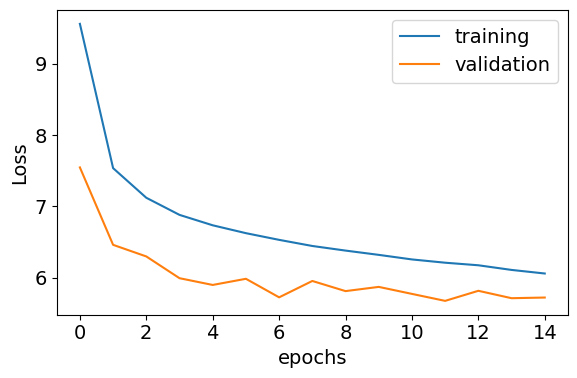

In [90]:
plot_loss(15, train_losses, val_losses,figsize=(6, 4))

2g fit: mu1 = 0.53, sigma = 0.64, n1  =0.60
2g fit: mu2 = -0.03, sigma = 2.30, n1  =0.40
weighted error: = 1.30
2g fit: mu1 = 0.05, sigma = 2.43, n1  =0.39
2g fit: mu2 = 0.22, sigma = 0.67, n1  =0.61
weighted error: = 1.35
2g fit: mu1 = 0.09, sigma = 2.48, n1  =0.36
2g fit: mu2 = -0.16, sigma = 0.69, n1  =0.64
weighted error: = 1.34


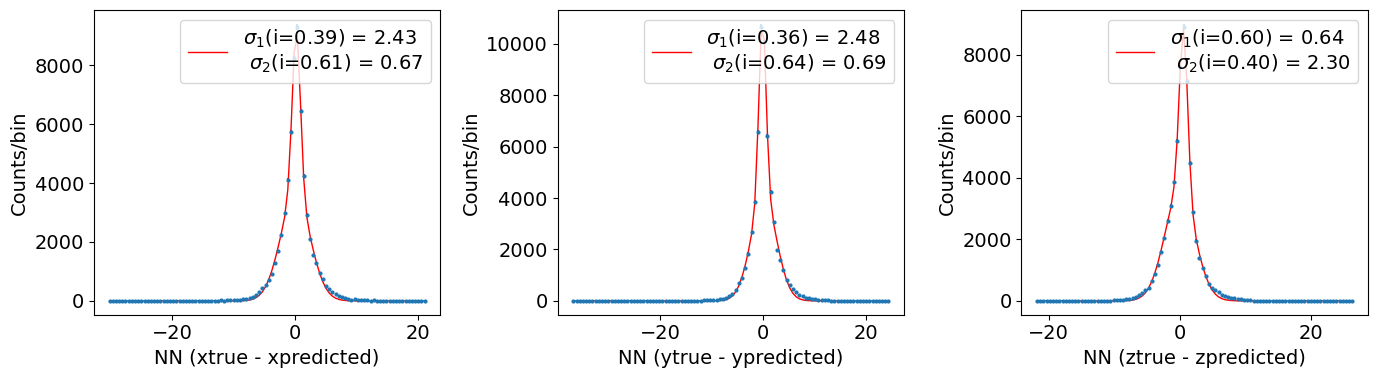

In [91]:
tdeltas = evaluate_cnn(test_loader, model, device)
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Case of 2c

In [92]:
img_names, csv_name = get_file_names_format1(d2c)
df2c = pd.read_csv(csv_name[0])
df2c.head(10)

,event_id,e1,x1,y1,z1,t1,e2,x2,y2,z2,t2,etot
0,1920003,0.103547,-13.831541,-19.600653,28.397263,0.203755,0.403007,-7.899639,-16.628996,31.025505,0.164303,0.506554
1,1920006,0.427367,-3.688032,-13.501049,36.721848,0.210866,0.080507,20.070265,-14.187165,3.878403,0.075633,0.507874
2,1920007,0.349917,11.824931,-12.249266,7.201409,0.085067,0.159520,8.605413,-15.776945,12.469618,0.126222,0.509436
3,1920016,0.013180,5.595923,-8.461670,6.927087,0.085813,0.495462,5.001655,-6.444003,15.166019,0.114177,0.508642
4,1920024,0.046576,-1.830718,18.280810,8.656804,0.089693,0.463346,-9.712315,20.902992,25.906824,0.153556,0.509922
5,1920025,0.170118,-0.467803,-16.089200,7.930560,0.088031,0.339073,1.670658,-20.853355,10.898421,0.108067,0.509190
6,1920027,0.109348,-17.714891,12.943513,17.586254,0.119465,0.398377,-14.155301,20.289745,26.057758,0.158707,0.507725
7,1920030,0.304436,-16.262854,6.271719,25.726223,0.148979,0.204724,-16.111063,14.994321,21.063805,0.181974,0.509160
8,1920034,0.429352,3.514499,1.769384,26.840360,0.182937,0.078310,17.023687,8.885761,11.638727,0.100276,0.507662
9,1920036,0.052112,-19.695612,7.217783,24.620066,0.143594,0.457727,-19.066397,12.504298,34.474613,0.180956,0.509840


In [93]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")



image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/df2c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 1683


In [94]:
df2cs = get_img_file_metadata(df2c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")

number of labels in file = 3049


In [137]:
def compute_positions(df):
    
    e1 = df["e1"]
    x1 = df["x1"]
    y1 = df["y1"]
    z1 = df["z1"]
    e2 = df["e2"]
    x2 = df["x2"]
    y2 = df["y2"]
    z2 = df["z2"]
    et = df["etot"]
    xb = (x1*e1 + x2 * e2)/et
    yb = (y1*e1 + y2 * e2)/et
    zb = (z1*e1 + z2 * e2)/et
    posx = namedtuple("posx", "x1,y1,z1,x2,y2,z2,xb,yb,zb")
    return posx(x1,y1,z1,x2,y2,z2,xb,yb,zb)

def plot_positions(x,y,z,xlbl, ylbl, zlbl):
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    flat_axes = axes.ravel()
    ax0, ax1, ax2 = flat_axes[0], flat_axes[1], flat_axes[2]
    
    ax0.hist(x, bins=50)
    ax0.set_xlabel(xlbl,fontsize=14)
    ax0.set_ylabel("Counts/bin",fontsize=14)
    
    ax1.hist(y, bins=50)
    ax1.set_xlabel(ylbl,fontsize=14)
    ax1.set_ylabel("Counts/bin",fontsize=14)
    
    ax2.hist(z, bins=50)
    ax2.set_xlabel(zlbl,fontsize=14)
    ax2.set_ylabel("Counts/bin",fontsize=14)
    plt.tight_layout()
    plt.show()
    

In [138]:
posx = compute_positions(df2c)

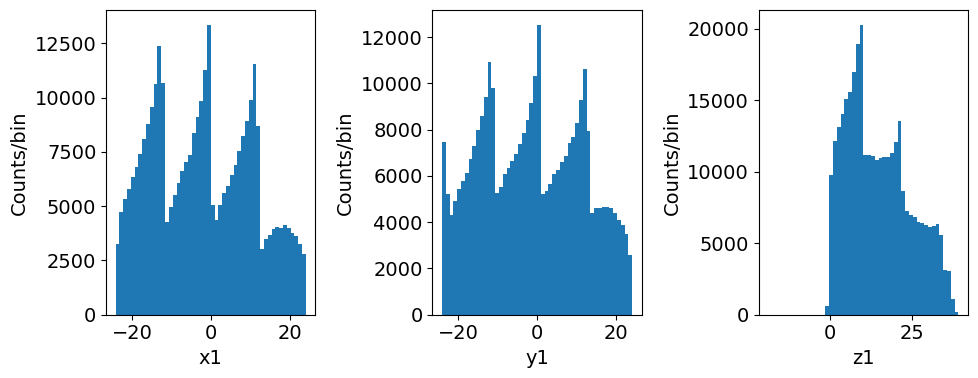

In [139]:
plot_positions(posx.x1,posx.y1,posx.z1,"x1", "y1", "z1")

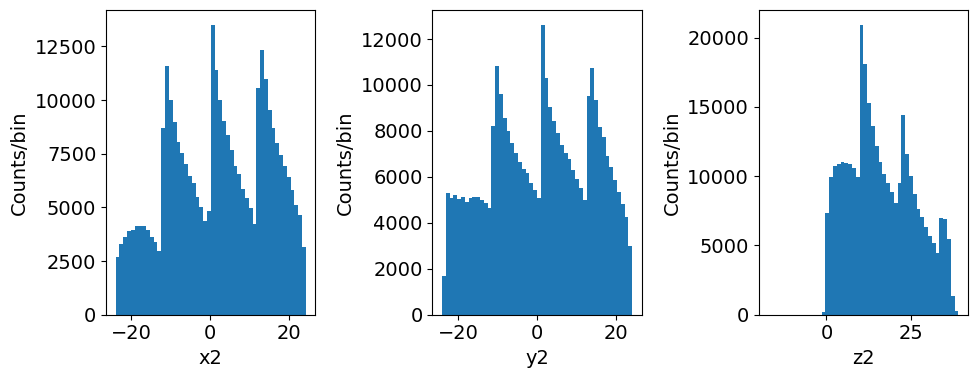

In [140]:
plot_positions(posx.x2,posx.y2,posx.z2,"x2", "y2", "z2")

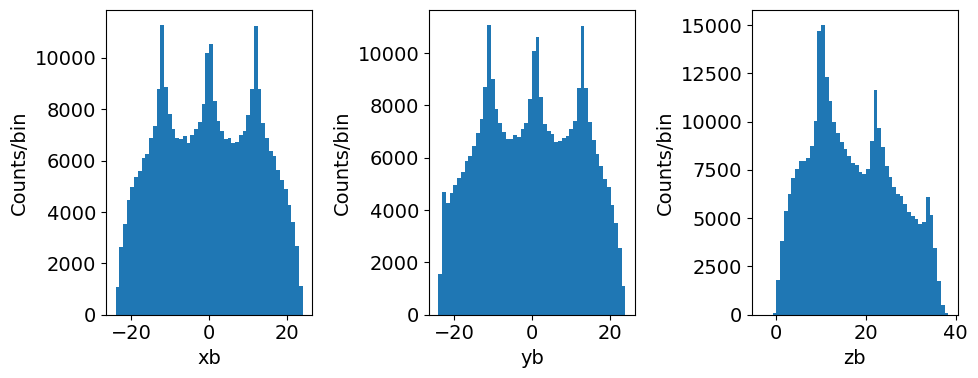

In [141]:
plot_positions(posx.xb,posx.yb,posx.zb,"xb", "yb", "zb")

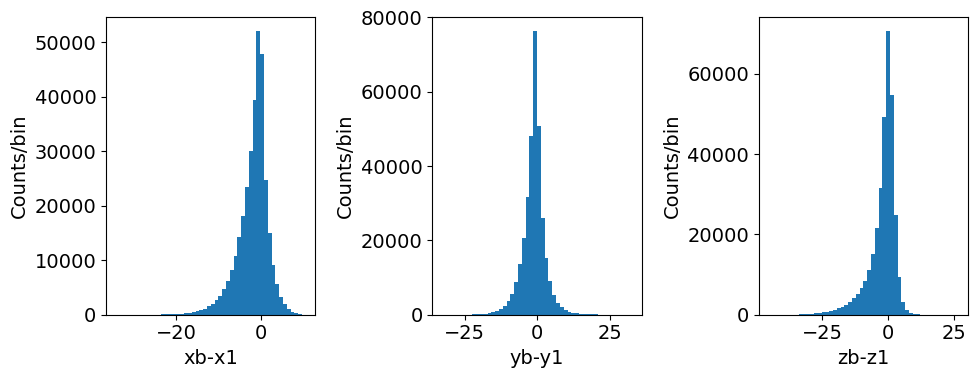

In [142]:
plot_positions(posx.x1 - posx.xb, posx.y1- posx.yb,posx.z1-posx.zb,"xb-x1", "yb-y1", "zb-z1")

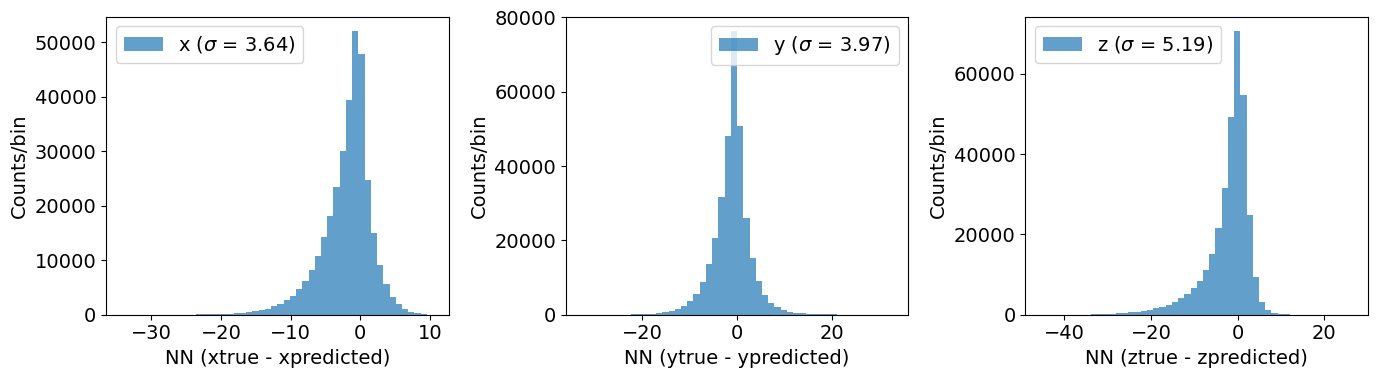

In [144]:
delta_x1 = posx.x1 - posx.xb
delta_y1 = posx.y1- posx.yb
delta_z1 = posx.z1-posx.zb

plotxyz(tdeltas(delta_x1, delta_y1, delta_z1), nbins=50)

2g fit: mu1 = 0.24, sigma = 1.23, n1  =0.56
2g fit: mu2 = -1.00, sigma = 3.78, n1  =0.44
weighted error: = 2.35
2g fit: mu1 = -0.43, sigma = 0.64, n1  =0.46
2g fit: mu2 = -1.00, sigma = 2.98, n1  =0.54
weighted error: = 1.90
2g fit: mu1 = -1.00, sigma = 3.36, n1  =0.48
2g fit: mu2 = -0.45, sigma = 0.76, n1  =0.52
weighted error: = 2.00


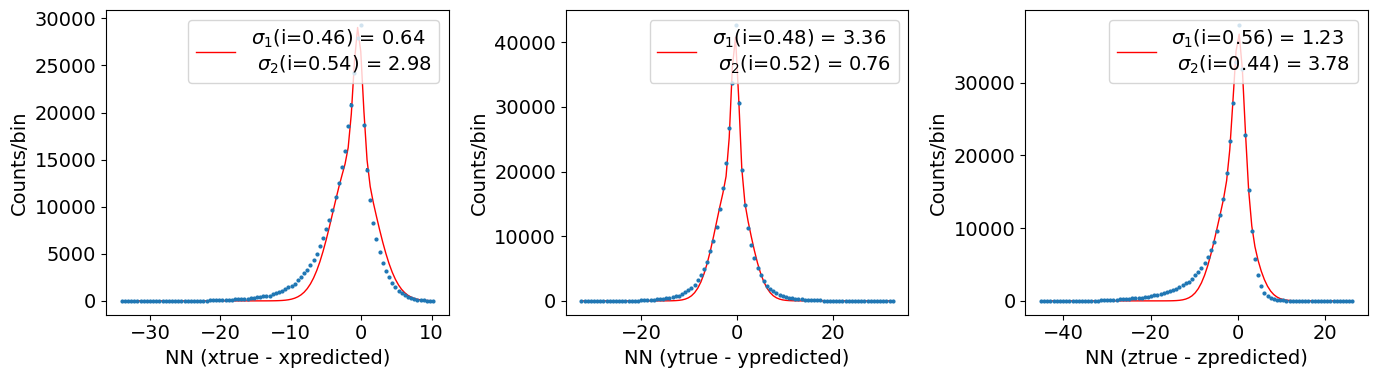

In [145]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas(delta_x1, delta_y1, delta_z1), bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

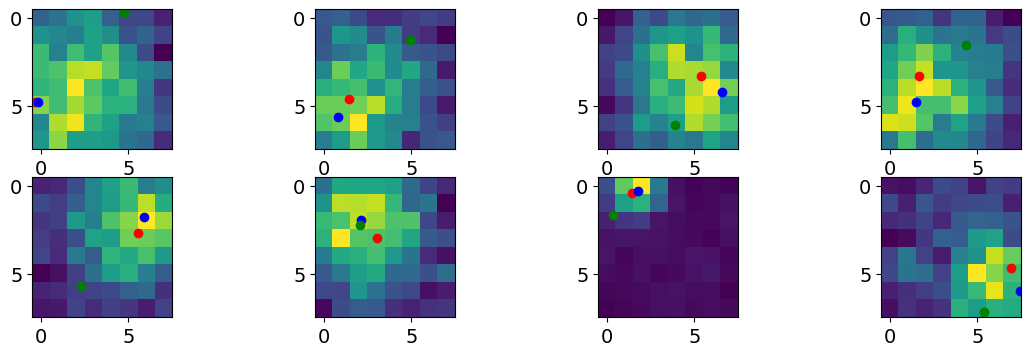

In [95]:
plot_images2c(imgs, df2cs, (0,8), pixel_size = 6, grid_size=8)

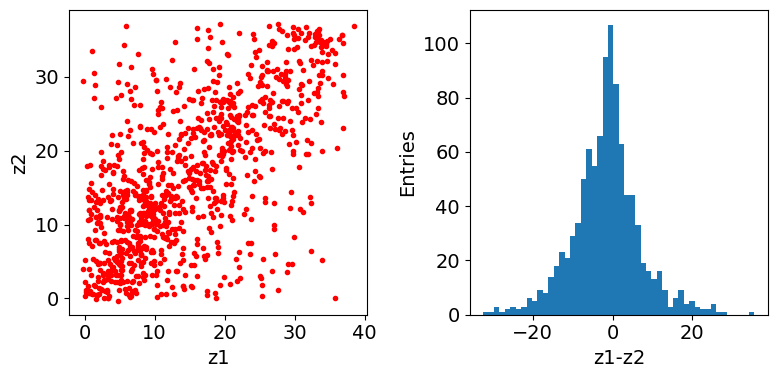

In [96]:
plot2c_z(df2cs, (0,1000),figsize=(8, 4))

In [97]:
dataset = RDataset(dir_root, first_file, last_file,type="2c", norm=False) 

Running rDataset with norm = False
Loading files in directory d2c with indexes: 0, 200
   event_id        e1         x1         y1         z1        t1        e2  \
0   1920003  0.103547 -13.831541 -19.600653  28.397263  0.203755  0.403007   
1   1920006  0.427367  -3.688032 -13.501049  36.721848  0.210866  0.080507   
2   1920007  0.349917  11.824931 -12.249266   7.201409  0.085067  0.159520   
3   1920016  0.013180   5.595923  -8.461670   6.927087  0.085813  0.495462   
4   1920024  0.046576  -1.830718  18.280810   8.656804  0.089693  0.463346   
5   1920025  0.170118  -0.467803 -16.089200   7.930560  0.088031  0.339073   
6   1920027  0.109348 -17.714891  12.943513  17.586254  0.119465  0.398377   
7   1920030  0.304436 -16.262854   6.271719  25.726223  0.148979  0.204724   
8   1920034  0.429352   3.514499   1.769384  26.840360  0.182937  0.078310   
9   1920036  0.052112 -19.695612   7.217783  24.620066  0.143594  0.457727   

          x2         y2         z2        t2      etot

In [98]:
dataset[0]

(tensor([[[ 58.,  63.,  72.,  76.,  57.,  50.,  50.,  41.],
          [ 72.,  69.,  66.,  77.,  71.,  53.,  58.,  49.],
          [ 85.,  67.,  86.,  77.,  89.,  70.,  51.,  34.],
          [ 85.,  88., 101., 102.,  91.,  73.,  69.,  62.],
          [ 83.,  86., 109.,  88.,  78.,  86.,  66.,  46.],
          [ 95.,  86.,  99.,  90.,  82.,  82.,  64.,  51.],
          [ 69., 100., 107.,  83.,  77.,  65.,  67.,  55.],
          [ 73.,  96.,  76.,  76.,  74.,  63.,  59.,  43.]]]),
 tensor([  7.6484, -23.0884,   4.7366]))

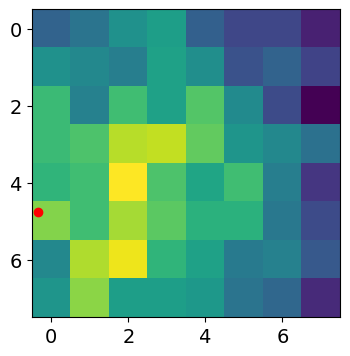

In [99]:
plot_dataset(dataset[0], pixel_size = 6, grid_size=8)

In [100]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 331628 events
 train size = 232139
 val size = 66325
 test size = 33164
 train indices = range(0, 232139)
 val indices = range(232139, 298464)
 test indices = range(298464, 331628)
232139 training events (69.99981907438455%)
66325 validation events (19.99981907438455%)
33164 test events (10.000361851230897%)


In [101]:
model = xCNN(clyrs,llyrs).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [102]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=15, iprnt=100)

Training with  ->232200 images
size of train loader  ->2322 images
Evaluating with  ->66400 images
size of eval loader  ->664 images
Running for epochs ->15

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 21.832568818387237
--- EPOCH 0 AVG VAL LOSS: 20.213968311447694

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 20.259897469858174
--- EPOCH 1 AVG VAL LOSS: 19.96069759489542

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 19.77145324217462
--- EPOCH 2 AVG VAL LOSS: 19.33749008609588

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 19.472852632159512
--- EPOCH 3 AVG VAL LOSS: 19.128723372896033

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 19.22455330700016
--- EPOCH 4 AVG VAL LOSS: 19.098704631070056

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 19.03486925933404
--- EPOCH 5 AVG VAL LOSS: 18.82413948300373

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 18.865602511768195
--- EPOCH 6 AVG VAL LOSS: 18.838071142334535

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 18.727940684243794
--- EPOCH 7 AVG VAL LOSS: 18.762426616197608

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 18.6

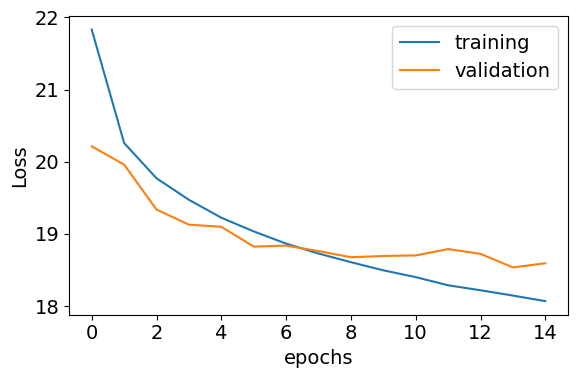

In [103]:
plot_loss(15, train_losses, val_losses,figsize=(6, 4))

2g fit: mu1 = 1.00, sigma = 3.25, n1  =0.89
2g fit: mu2 = -1.00, sigma = 8.08, n1  =0.11
weighted error: = 3.81
2g fit: mu1 = -0.06, sigma = 4.28, n1  =0.40
2g fit: mu2 = 0.67, sigma = 1.95, n1  =0.60
weighted error: = 2.88
2g fit: mu1 = 0.07, sigma = 4.21, n1  =0.51
2g fit: mu2 = 0.25, sigma = 1.65, n1  =0.49
weighted error: = 2.95


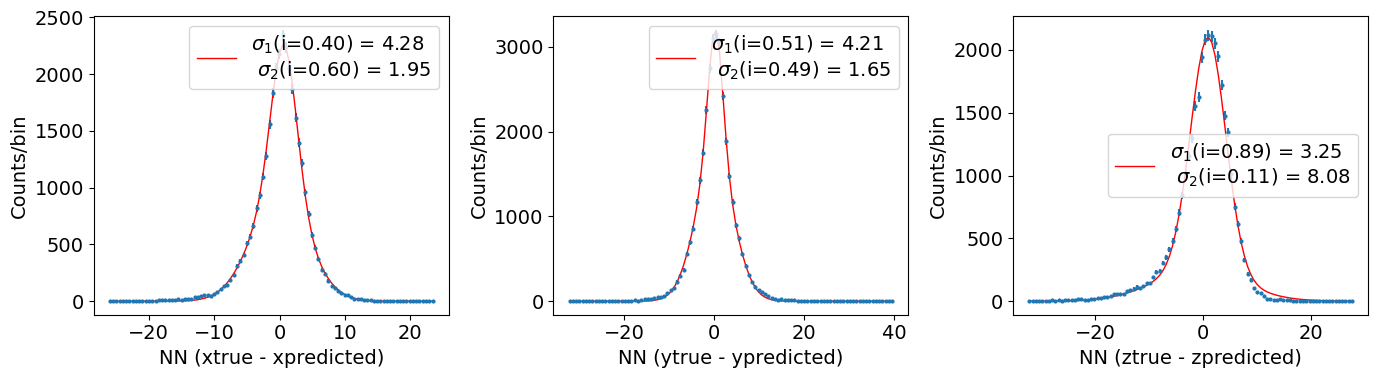

In [104]:
tdeltas = evaluate_cnn(test_loader, model, device)
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [105]:
model2 = xCNN(clyrs,llyrs2).to(device)

In [106]:
summary(model2,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
         LeakyReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
         LeakyReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
        LeakyReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [107]:
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [108]:
dataset2 = R2Dataset(dir_root, first_file, last_file, norm=False) 

Running rDataset with norm = False
Loading files in directory d2c with indexes: 0, 200
   event_id        e1         x1         y1         z1        t1        e2  \
0   1920003  0.103547 -13.831541 -19.600653  28.397263  0.203755  0.403007   
1   1920006  0.427367  -3.688032 -13.501049  36.721848  0.210866  0.080507   
2   1920007  0.349917  11.824931 -12.249266   7.201409  0.085067  0.159520   
3   1920016  0.013180   5.595923  -8.461670   6.927087  0.085813  0.495462   
4   1920024  0.046576  -1.830718  18.280810   8.656804  0.089693  0.463346   
5   1920025  0.170118  -0.467803 -16.089200   7.930560  0.088031  0.339073   
6   1920027  0.109348 -17.714891  12.943513  17.586254  0.119465  0.398377   
7   1920030  0.304436 -16.262854   6.271719  25.726223  0.148979  0.204724   
8   1920034  0.429352   3.514499   1.769384  26.840360  0.182937  0.078310   
9   1920036  0.052112 -19.695612   7.217783  24.620066  0.143594  0.457727   

          x2         y2         z2        t2      etot

In [109]:
dataset2[0]

(tensor([[[ 58.,  63.,  72.,  76.,  57.,  50.,  50.,  41.],
          [ 72.,  69.,  66.,  77.,  71.,  53.,  58.,  49.],
          [ 85.,  67.,  86.,  77.,  89.,  70.,  51.,  34.],
          [ 85.,  88., 101., 102.,  91.,  73.,  69.,  62.],
          [ 83.,  86., 109.,  88.,  78.,  86.,  66.,  46.],
          [ 95.,  86.,  99.,  90.,  82.,  82.,  64.,  51.],
          [ 69., 100., 107.,  83.,  77.,  65.,  67.,  55.],
          [ 73.,  96.,  76.,  76.,  74.,  63.,  59.,  43.]]]),
 tensor([  7.6484, -23.0884,   4.7366,   7.6299, -21.9073,   3.1503]))

In [110]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset2, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 331628 events
 train size = 232139
 val size = 66325
 test size = 33164
 train indices = range(0, 232139)
 val indices = range(232139, 298464)
 test indices = range(298464, 331628)
232139 training events (69.99981907438455%)
66325 validation events (19.99981907438455%)
33164 test events (10.000361851230897%)


In [111]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model2, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->232200 images
size of train loader  ->2322 images
Evaluating with  ->66400 images
size of eval loader  ->664 images
Running for epochs ->20

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 23.00546238609268
--- EPOCH 0 AVG VAL LOSS: 18.33002376843648

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 18.848498422867465
--- EPOCH 1 AVG VAL LOSS: 17.96945875667664

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 18.2911173629925
--- EPOCH 2 AVG VAL LOSS: 17.927494963967657

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 17.97576341127959
--- EPOCH 3 AVG VAL LOSS: 17.54916471458343

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 17.71069405717546
--- EPOCH 4 AVG VAL LOSS: 17.4265502159854

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 17.526323089303897
--- EPOCH 5 AVG VAL LOSS: 17.483126065817224

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 17.366757863970484
--- EPOCH 6 AVG VAL LOSS: 17.239183072584222

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 17.215010256935663
--- EPOCH 7 AVG VAL LOSS: 17.48166761484491

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 17.125382

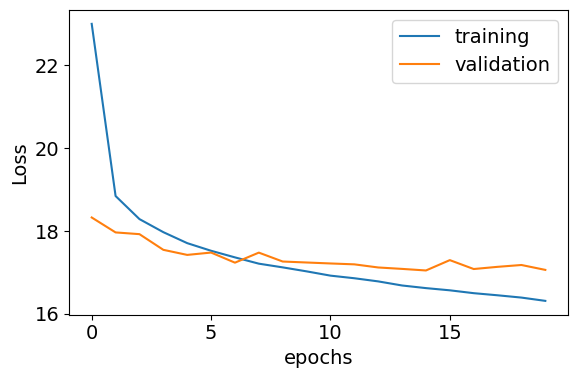

In [112]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

In [113]:
td12 =evaluate_2c_cnn(test_loader, model2, device)
   


In [114]:
delta_x1 = td12.true_x1 - td12.pred_x1
delta_y1 = td12.true_y1 - td12.pred_y1
delta_z1 = td12.true_z1 - td12.pred_z1
tdeltas = namedtuple('tdeltas','delta_x_NN, delta_y_NN, delta_z_NN')

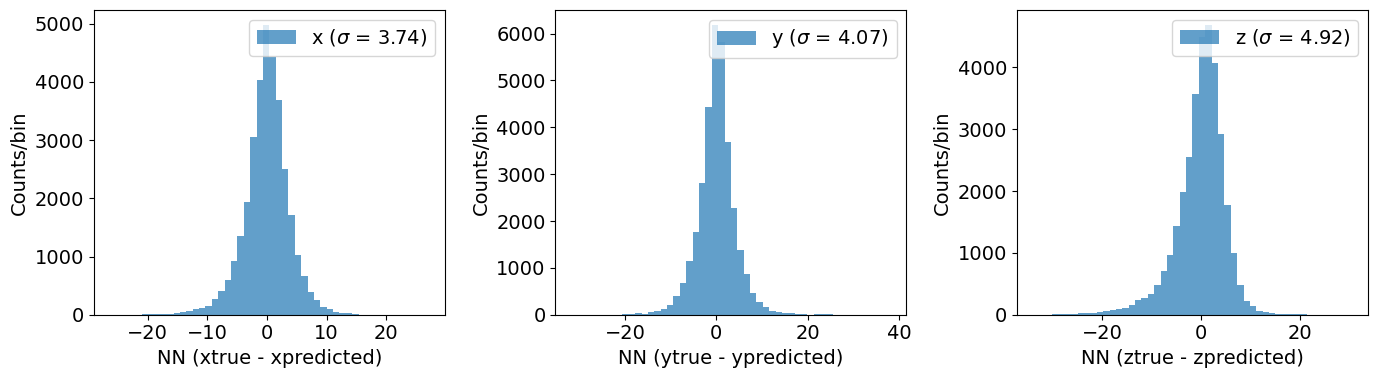

In [115]:
plotxyz(tdeltas(delta_x1, delta_y1, delta_z1), nbins=50)

2g fit: mu1 = -1.00, sigma = 6.39, n1  =0.22
2g fit: mu2 = 1.00, sigma = 2.79, n1  =0.78
weighted error: = 3.59
2g fit: mu1 = 0.18, sigma = 1.93, n1  =0.58
2g fit: mu2 = -0.01, sigma = 4.21, n1  =0.42
weighted error: = 2.88
2g fit: mu1 = -0.03, sigma = 4.15, n1  =0.49
2g fit: mu2 = 0.19, sigma = 1.51, n1  =0.51
weighted error: = 2.81


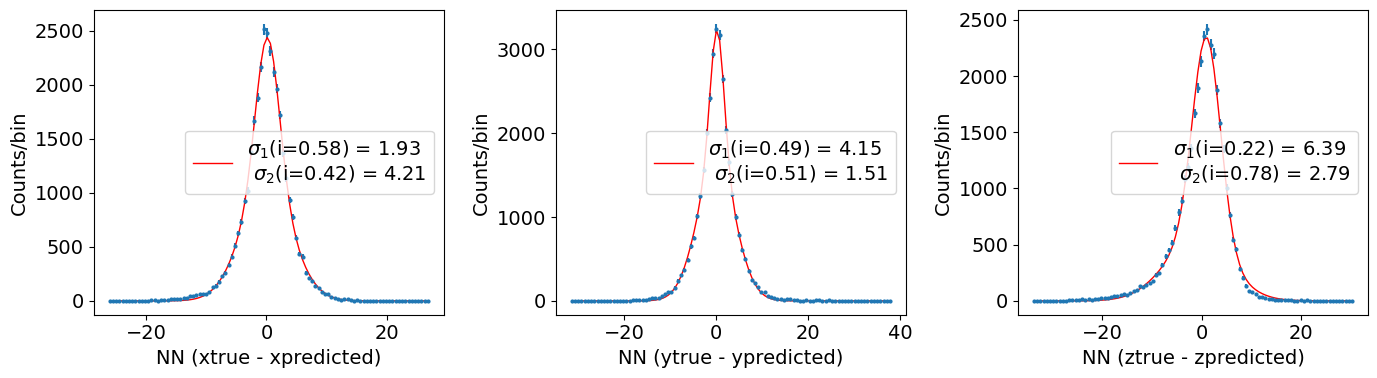

In [116]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas(delta_x1, delta_y1, delta_z1), bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [117]:
delta_x2 = td12.true_x2 - td12.pred_x2
delta_y2 = td12.true_y2 - td12.pred_y2
delta_z2 = td12.true_z2 - td12.pred_z2

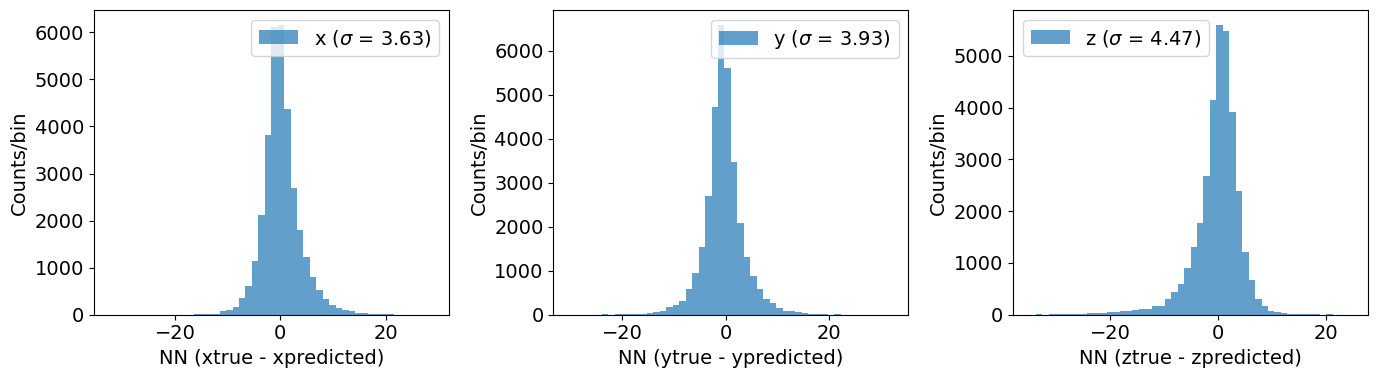

In [118]:
plotxyz(tdeltas(delta_x2, delta_y2, delta_z2), nbins=50)

2g fit: mu1 = 0.97, sigma = 1.83, n1  =0.70
2g fit: mu2 = -0.48, sigma = 4.55, n1  =0.30
weighted error: = 2.65
2g fit: mu1 = -0.51, sigma = 1.50, n1  =0.63
2g fit: mu2 = 0.39, sigma = 3.98, n1  =0.37
weighted error: = 2.43
2g fit: mu1 = -0.66, sigma = 1.46, n1  =0.65
2g fit: mu2 = -0.29, sigma = 4.15, n1  =0.35
weighted error: = 2.41


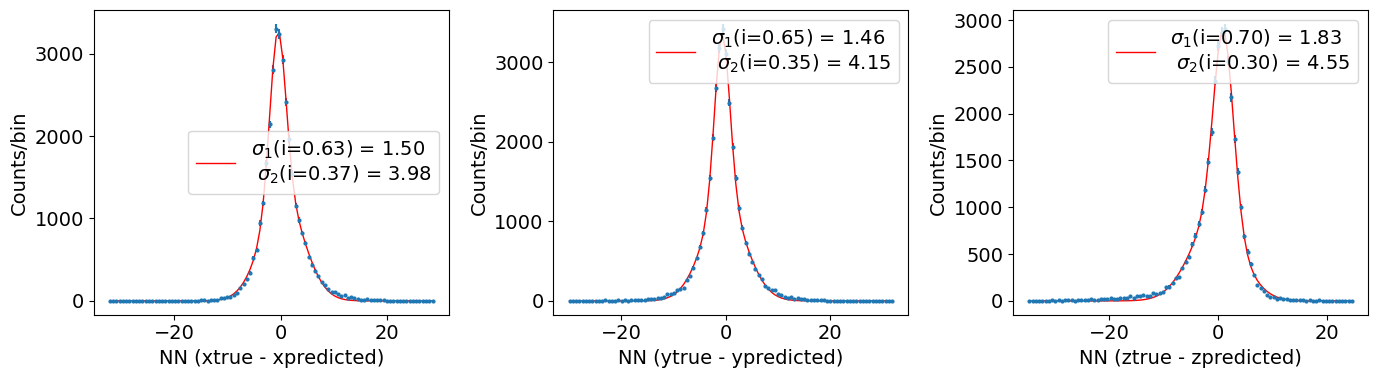

In [120]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas(delta_x2, delta_y2, delta_z2), bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Resnet

In [121]:
model2 = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 6, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [122]:
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [123]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model2, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->232200 images
size of train loader  ->2322 images
Evaluating with  ->66400 images
size of eval loader  ->664 images
Running for epochs ->20

EPOCH 0
  ResNet8: input data shape =>torch.Size([100, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([100, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([100, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([100, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([100, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([100, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([100, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([100, 512])
  ResNet8: after fc =>torch.Size([100, 6])
--- EPOCH 0 AVG TRAIN LOSS: 23.785389330549346
--- EPOCH 0 AVG VAL LOSS: 19.939455737550574

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 20.277607504608916
--- EPOCH 1 AVG VAL LOSS: 18.733107703277863

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 19.38103918203704
--- EPOCH 2 AVG VAL LOSS: 17.923249767487306

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 18.88928690745233
--- EPOC

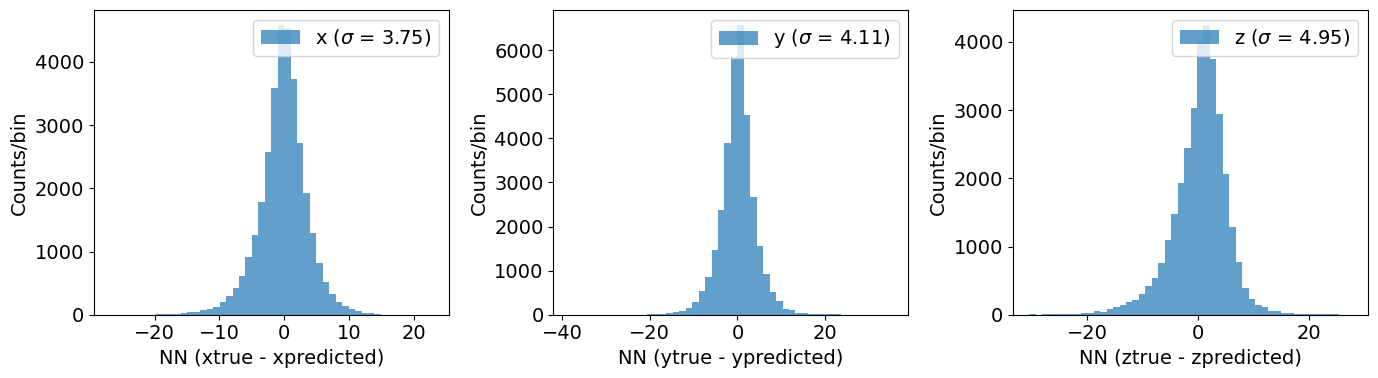

In [124]:
td12 =evaluate_2c_cnn(test_loader, model2, device)
delta_x1 = td12.true_x1 - td12.pred_x1
delta_y1 = td12.true_y1 - td12.pred_y1
delta_z1 = td12.true_z1 - td12.pred_z1
plotxyz(tdeltas(delta_x1, delta_y1, delta_z1), nbins=50)

2g fit: mu1 = -0.47, sigma = 7.49, n1  =0.16
2g fit: mu2 = 1.00, sigma = 3.08, n1  =0.84
weighted error: = 3.81
2g fit: mu1 = -0.09, sigma = 4.04, n1  =0.47
2g fit: mu2 = 0.12, sigma = 1.68, n1  =0.53
weighted error: = 2.79
2g fit: mu1 = 0.30, sigma = 1.61, n1  =0.53
2g fit: mu2 = 0.00, sigma = 4.24, n1  =0.47
weighted error: = 2.84


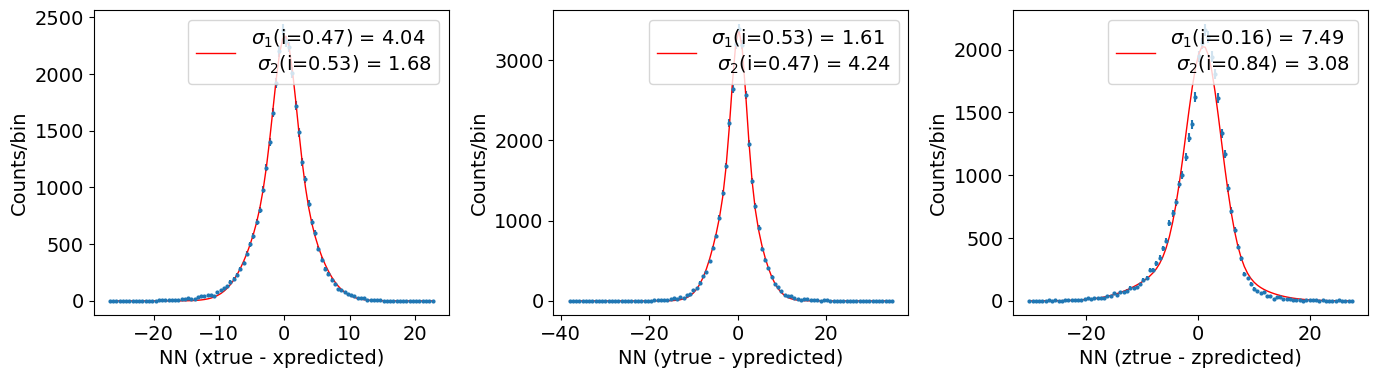

In [125]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas(delta_x1, delta_y1, delta_z1), bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

2g fit: mu1 = 0.97, sigma = 1.83, n1  =0.70
2g fit: mu2 = -0.48, sigma = 4.55, n1  =0.30
weighted error: = 2.65
2g fit: mu1 = -0.51, sigma = 1.50, n1  =0.63
2g fit: mu2 = 0.39, sigma = 3.98, n1  =0.37
weighted error: = 2.43
2g fit: mu1 = -0.66, sigma = 1.46, n1  =0.65
2g fit: mu2 = -0.29, sigma = 4.15, n1  =0.35
weighted error: = 2.41


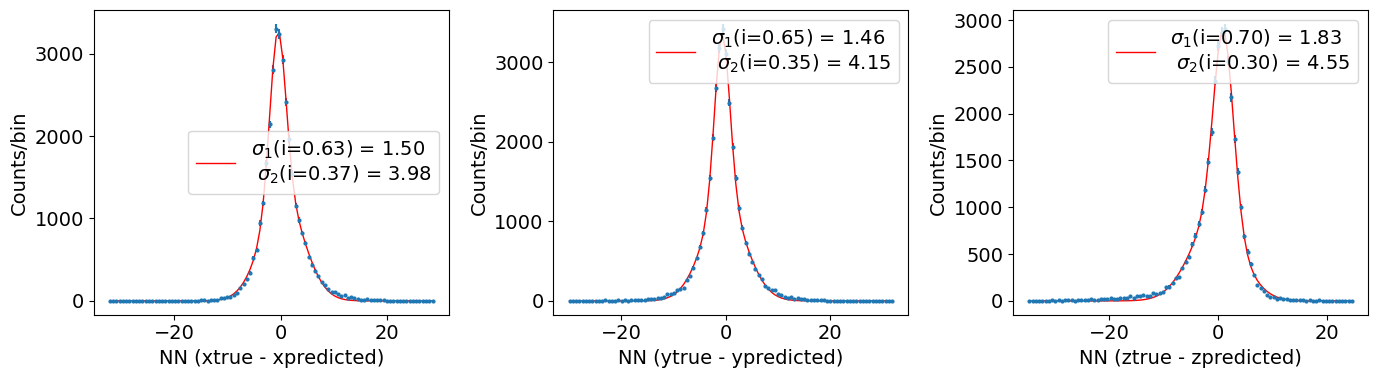

In [126]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas(delta_x2, delta_y2, delta_z2), bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Using barycenter

In [128]:
datasetb = R2Dataset(dir_root, first_file, last_file, bcnt=True, norm=False) 

Running rDataset with norm = False
Loading files in directory d2c with indexes: 0, 200
   event_id        e1         x1         y1         z1        t1        e2  \
0   1920003  0.103547 -13.831541 -19.600653  28.397263  0.203755  0.403007   
1   1920006  0.427367  -3.688032 -13.501049  36.721848  0.210866  0.080507   
2   1920007  0.349917  11.824931 -12.249266   7.201409  0.085067  0.159520   
3   1920016  0.013180   5.595923  -8.461670   6.927087  0.085813  0.495462   
4   1920024  0.046576  -1.830718  18.280810   8.656804  0.089693  0.463346   
5   1920025  0.170118  -0.467803 -16.089200   7.930560  0.088031  0.339073   
6   1920027  0.109348 -17.714891  12.943513  17.586254  0.119465  0.398377   
7   1920030  0.304436 -16.262854   6.271719  25.726223  0.148979  0.204724   
8   1920034  0.429352   3.514499   1.769384  26.840360  0.182937  0.078310   
9   1920036  0.052112 -19.695612   7.217783  24.620066  0.143594  0.457727   

          x2         y2         z2        t2      etot

In [129]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(datasetb, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 331628 events
 train size = 232139
 val size = 66325
 test size = 33164
 train indices = range(0, 232139)
 val indices = range(232139, 298464)
 test indices = range(298464, 331628)
232139 training events (69.99981907438455%)
66325 validation events (19.99981907438455%)
33164 test events (10.000361851230897%)


In [130]:
modelb = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 3, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)
optimizer = optim.Adam(modelb.parameters(), lr=0.001)
criterion = nn.MSELoss()

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [131]:
train_losses, val_losses = train_cnn(train_loader, val_loader, modelb, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->232200 images
size of train loader  ->2322 images
Evaluating with  ->66400 images
size of eval loader  ->664 images
Running for epochs ->20

EPOCH 0
  ResNet8: input data shape =>torch.Size([100, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([100, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([100, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([100, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([100, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([100, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([100, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([100, 512])
  ResNet8: after fc =>torch.Size([100, 3])
--- EPOCH 0 AVG TRAIN LOSS: 8.814366861009885
--- EPOCH 0 AVG VAL LOSS: 6.18493848105511

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 6.560902915773055
--- EPOCH 1 AVG VAL LOSS: 5.3682731375636825

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 6.101374743110039
--- EPOCH 2 AVG VAL LOSS: 5.035141885998738

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 5.85301644405756
--- EPOCH 3 AV

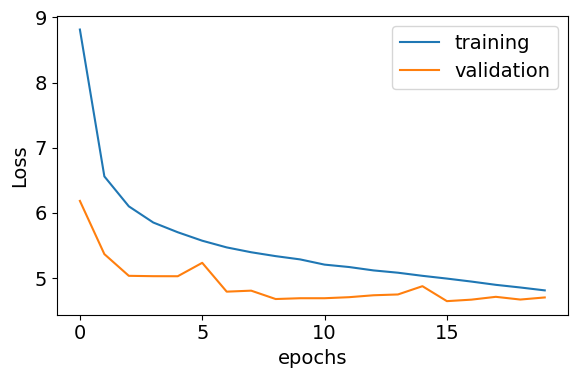

In [132]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))


2g fit: mu1 = 0.12, sigma = 2.40, n1  =0.34
2g fit: mu2 = 0.37, sigma = 0.83, n1  =0.66
weighted error: = 1.36
2g fit: mu1 = 0.23, sigma = 2.39, n1  =0.38
2g fit: mu2 = -0.00, sigma = 0.86, n1  =0.62
weighted error: = 1.44
2g fit: mu1 = -0.09, sigma = 2.29, n1  =0.38
2g fit: mu2 = -0.31, sigma = 0.75, n1  =0.62
weighted error: = 1.34


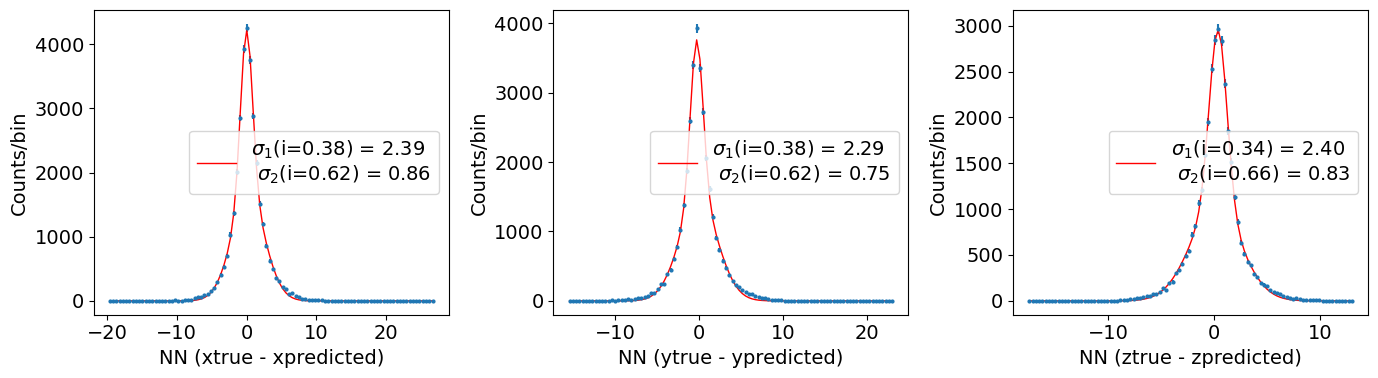

In [134]:
tdeltas = evaluate_cnn(test_loader, modelb, device)
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Classification

In [211]:
dataset = XDataset(dir_root, first_file, last_file,norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 512770, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 512770, si->[115481, 208736, 461043, 162373, 418200, 479114, 338695, 506523, 461126, 152977]


In [212]:
dataset[3]

(tensor([[[198., 228., 246., 223., 214., 186., 171., 148.],
          [231., 273., 279., 259., 226., 175., 193., 155.],
          [247., 259., 300., 285., 251., 202., 193., 170.],
          [240., 277., 262., 265., 250., 219., 170., 153.],
          [228., 246., 235., 220., 249., 231., 171., 174.],
          [192., 199., 243., 208., 211., 211., 167., 166.],
          [184., 159., 209., 198., 174., 159., 164., 143.],
          [146., 187., 199., 185., 171., 149., 131., 125.]]]),
 tensor(0))

In [213]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 512770 events
 train size = 358939
 val size = 102554
 test size = 51277
 train indices = range(0, 358939)
 val indices = range(358939, 461493)
 test indices = range(461493, 512770)
358939 training events (70.0%)
102554 validation events (20.0%)
51277 test events (10.0%)


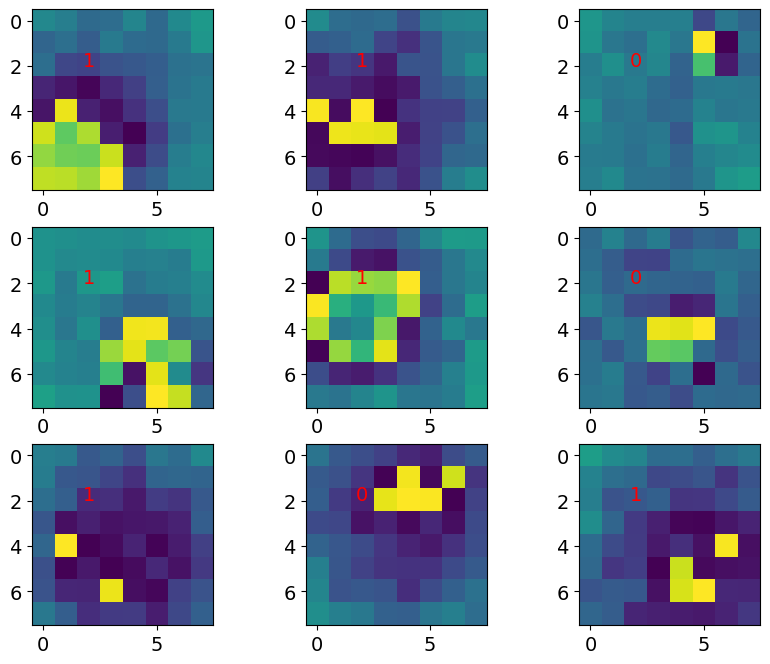

In [214]:
plot_images_and_labels(train_loader, start=100, figsize=(10, 8))

In [38]:
model = CNN(clyrs,llyrs).to(device)

In [224]:
summary(modelx,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
              ReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
             ReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [225]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelx.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [226]:
x_single_run(train_loader, device, model, optimizer, criterion, xc=True)

** Run for 1 event**
epoch = 0
i = 0
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8])
labels = tensor([1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0])
outputs = torch.Size([100, 3])
predicted label = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        2, 1, 1, 1], device='cuda:0')
correct = 32
Train Step 1/3590, Loss: 1.1091334819793701
i = 1
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8

In [227]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, modelx, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.6432508803011647
--- EPOCH 0 AVG VAL LOSS: 0.6194528091488294
Accuracy on the 1026 validation images: 65.23587573375977 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.6157789945187343
--- EPOCH 1 AVG VAL LOSS: 0.6072487829953839
Accuracy on the 1026 validation images: 66.716071533046 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.6069532998674095
--- EPOCH 2 AVG VAL LOSS: 0.608467973289434
Accuracy on the 1026 validation images: 66.3026308091347 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.6019900270574

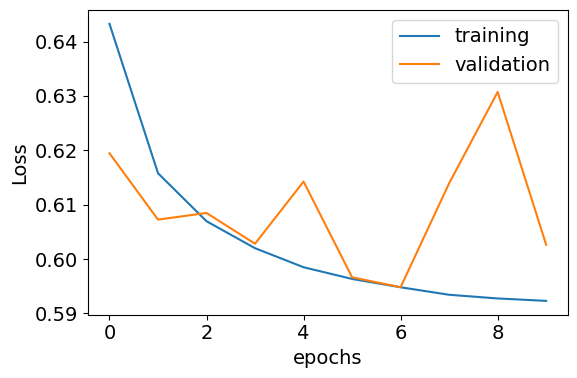

In [228]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

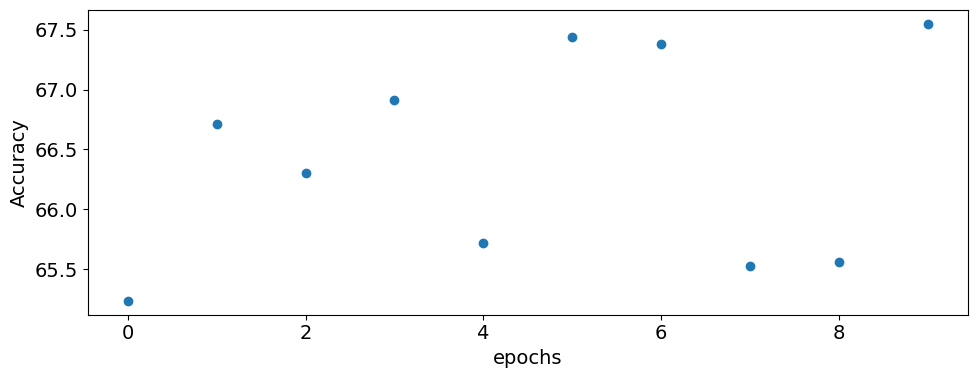

In [229]:
plot_accuracy(acc, figsize=(10, 4))

## Normalization

In [230]:
means, stds = get_means_stds2(dir=d1c)

files in dir: 100
shape -> (3027, 8, 8)
mean img0 =205.46875
std  img0 =33.66422653198242


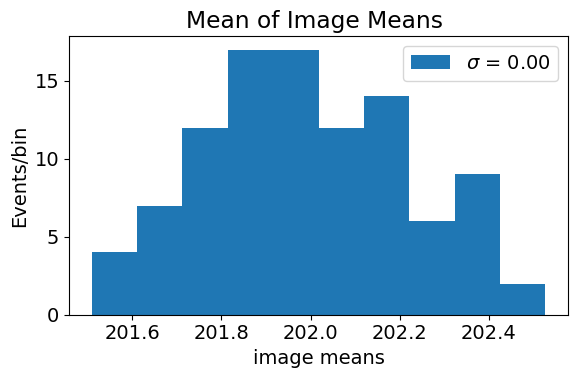

In [231]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [232]:
imean = np.mean(meansx)

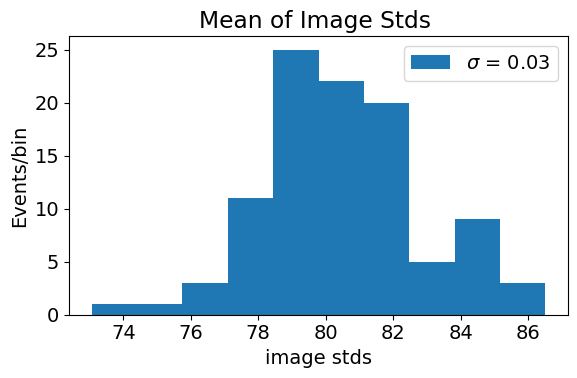

In [233]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [234]:
isigma = np.mean(stdsx)

In [235]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 201.99266052246094, std = 80.52242279052734


In [236]:
means2, stds2 = get_means_stds2(dir=d2c)

files in dir: 100
shape -> (1682, 8, 8)
mean img0 =199.0625
std  img0 =37.01303482055664


In [237]:
folder_h5    = "CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5"

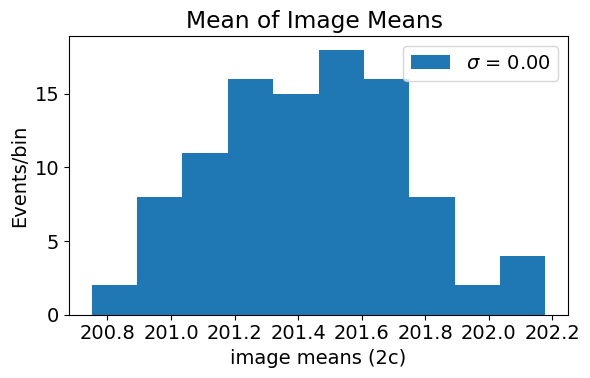

In [238]:
meansx2 =[np.mean(x) for x in means2]
histoplot(meansx2, "image means (2c)", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [239]:
imean2 = np.mean(meansx2)

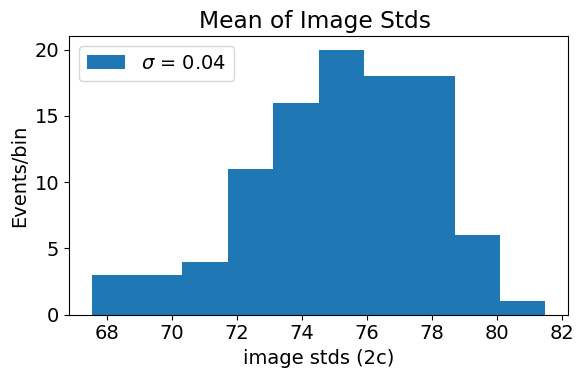

In [240]:
stdsx2 =[np.std(x) for x in stds2]
histoplot(stdsx2, "image stds (2c)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [241]:
isigma2 = np.mean(stdsx2)

In [242]:
print(f"Normalization 2c: mean = {imean2}, std = {isigma2}")

Normalization 2c: mean = 201.4387664794922, std = 75.14452362060547


In [243]:
means3, stds3 = get_means_stds2(dir=dnc)

files in dir: 100
shape -> (382, 8, 8)
mean img0 =199.28125
std  img0 =51.78937911987305


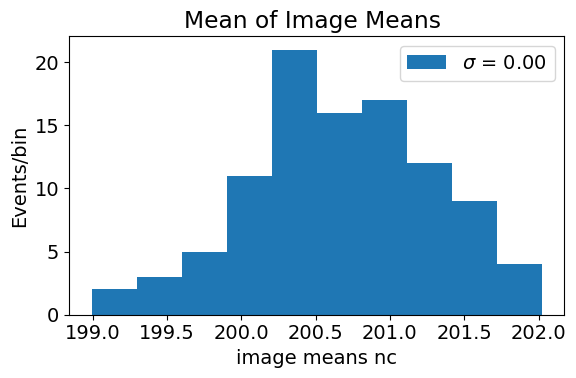

In [244]:
meansx3 =[np.mean(x) for x in means3]
histoplot(meansx3, "image means nc", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [245]:
imean3 = np.mean(meansx3)

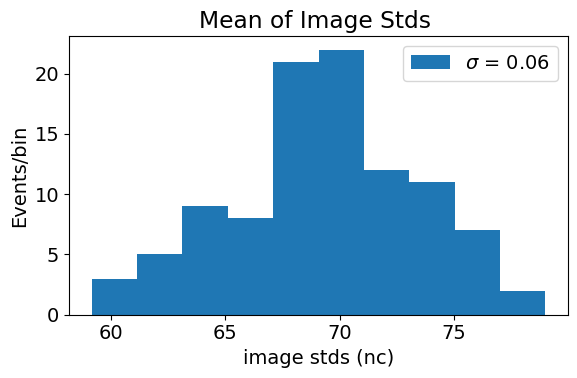

In [246]:
stdsx3 =[np.std(x) for x in stds3]
histoplot(stdsx3, "image stds (nc)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [247]:
isigma3 = np.mean(stdsx3)

In [248]:
print(f"Normalization nc: mean = {imean3}, std = {isigma3}")

Normalization nc: mean = 200.6782684326172, std = 69.30697631835938


### Run with full stats and normalization

In [249]:
dataset = XDataset(dir_root, first_file, last_file,norm=True, mean=imean, std=isigma)  # No comparison with energy only xyz


Running XDataset with norm = True
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 512770, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 512770, si->[115481, 208736, 461043, 162373, 418200, 479114, 338695, 506523, 461126, 152977]


In [250]:
dataset[3]

(tensor([[[-4.9584e-02,  3.2298e-01,  5.4652e-01,  2.6089e-01,  1.4912e-01,
           -1.9861e-01, -3.8489e-01, -6.7053e-01],
          [ 3.6024e-01,  8.8183e-01,  9.5635e-01,  7.0797e-01,  2.9814e-01,
           -3.3522e-01, -1.1168e-01, -5.8360e-01],
          [ 5.5894e-01,  7.0797e-01,  1.2171e+00,  1.0309e+00,  6.0862e-01,
            9.1148e-05, -1.1168e-01, -3.9731e-01],
          [ 4.7201e-01,  9.3151e-01,  7.4523e-01,  7.8248e-01,  5.9620e-01,
            2.1121e-01, -3.9731e-01, -6.0843e-01],
          [ 3.2298e-01,  5.4652e-01,  4.0991e-01,  2.2363e-01,  5.8378e-01,
            3.6024e-01, -3.8489e-01, -3.4764e-01],
          [-1.2410e-01, -3.7166e-02,  5.0927e-01,  7.4605e-02,  1.1186e-01,
            1.1186e-01, -4.3457e-01, -4.4699e-01],
          [-2.2345e-01, -5.3392e-01,  8.7023e-02, -4.9584e-02, -3.4764e-01,
           -5.3392e-01, -4.7183e-01, -7.3262e-01],
          [-6.9537e-01, -1.8619e-01, -3.7166e-02, -2.1103e-01, -3.8489e-01,
           -6.5811e-01, -8.8165e-01

In [251]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 512770 events
 train size = 358939
 val size = 102554
 test size = 51277
 train indices = range(0, 358939)
 val indices = range(358939, 461493)
 test indices = range(461493, 512770)
358939 training events (70.0%)
102554 validation events (20.0%)
51277 test events (10.0%)


In [254]:
modelx = xCNN(clyrs,llyrsx).to(device)

In [255]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelx.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [256]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, modelx, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.5920797410200566
--- EPOCH 0 AVG VAL LOSS: 0.5824538770823451
Accuracy on the 1026 validation images: 68.72866977397274 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.5889770638975924
--- EPOCH 1 AVG VAL LOSS: 0.5863201414283953
Accuracy on the 1026 validation images: 68.40688807847573 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.5885834292947084
--- EPOCH 2 AVG VAL LOSS: 0.5839827657326853
Accuracy on the 1026 validation images: 68.69161612418823 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.586564110

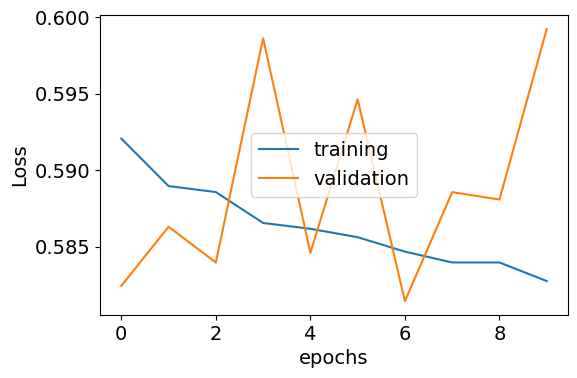

In [257]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

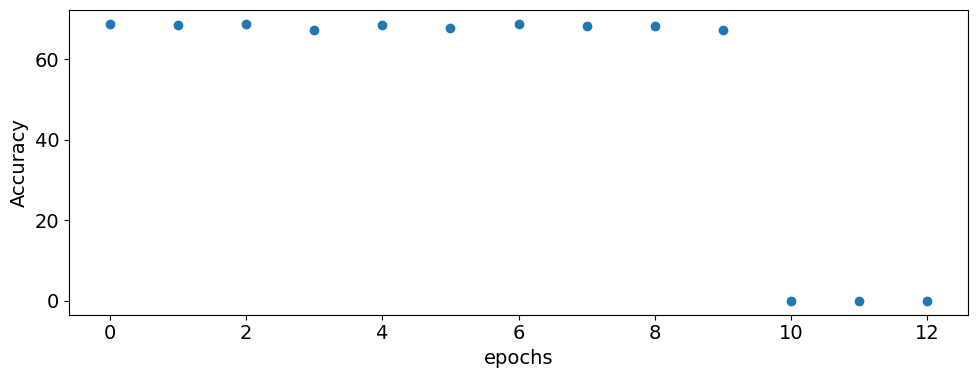

In [261]:
plot_accuracy(acc,figsize=(10, 4))

## Resnet

In [264]:
modelx = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 2, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [265]:
summary(modelx,(1,8,8))

  ResNet8: input data shape =>torch.Size([2, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([2, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([2, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([2, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([2, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([2, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([2, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([2, 512])
  ResNet8: after fc =>torch.Size([2, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7       

In [266]:
optimizer= optim.Adam(modelx.parameters(), lr=0.001)

In [267]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, modelx, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.6245760484824273
--- EPOCH 0 AVG VAL LOSS: 0.5938851587314588
Accuracy on the 1026 validation images: 67.6248610488133 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.5882317860727523
--- EPOCH 1 AVG VAL LOSS: 0.5795969873027728
Accuracy on the 1026 validation images: 68.81935370634008 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.5776797405275462
--- EPOCH 2 AVG VAL LOSS: 0.5803349299853773
Accuracy on the 1026 validation images: 68.83690543518537 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.5689500268

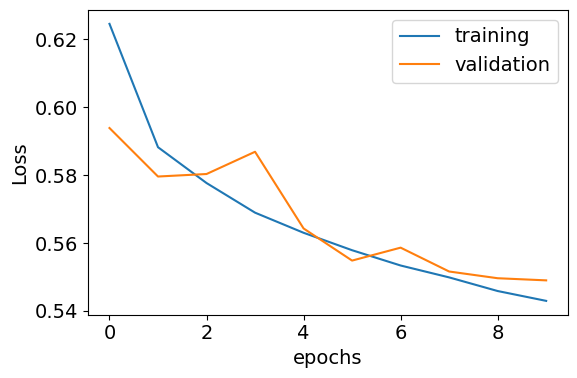

In [268]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

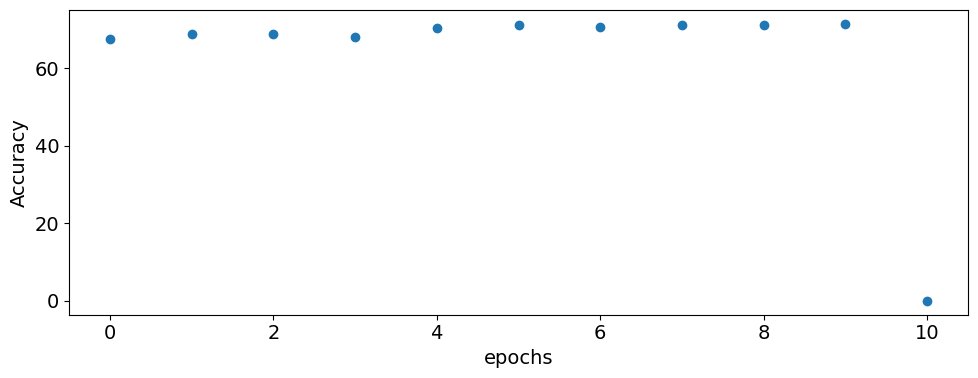

In [269]:
plot_accuracy(acc,figsize=(10, 4))

## Study accuracy

In [270]:
dataset1c = XDataset(dir_root, first_file, last_file, type="1c", norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/dfnc
 Image type = 0
Before shufle: length si: 305080, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 305080, si->[187431, 187255, 204628, 170887, 44287, 157519, 141100, 226100, 210928, 180817]


In [271]:
data_loader = DataLoader(dataset1c, batch_size=10, shuffle=False) # data already shuffled

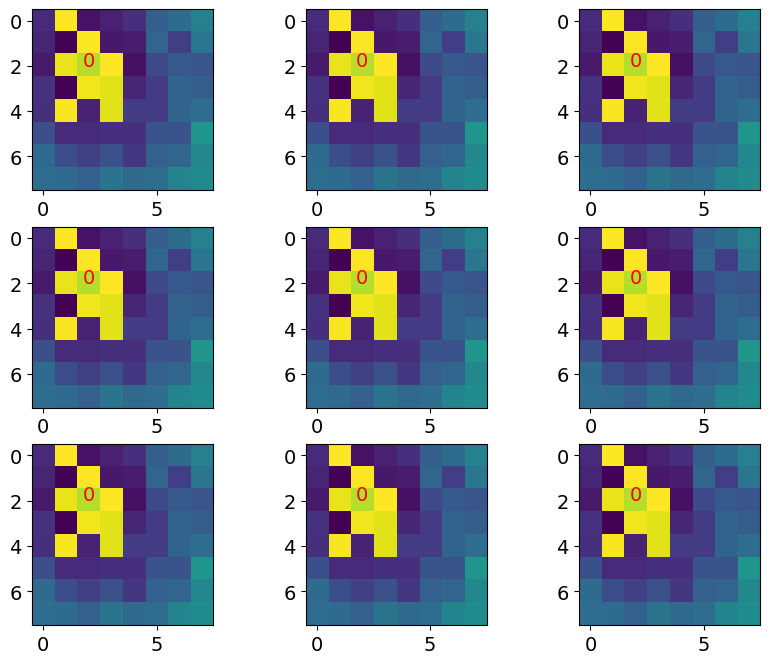

In [272]:
plot_images_and_labels(data_loader, start=0, figsize=(10, 8))

In [273]:
total, t1c, t2c, acc, c1c, c2c = cnn_xeval(test_loader, modelx, device, prnt=1000) 
print(f"Events analyzed = {total}: 1c = {t1c}, 2c = {t2c}")
print(f"Events correctly identified = {acc}")
print(f"1c correctly identified as 1c = {c1c}")
print(f"2c correctly identified as 2c = {c2c}")

Validation step: size of sample 513
i = 0
labels = tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0], device='cuda:0')
predicted = tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0], device='cuda:0')
correct = 65
labels 0 = tensor([ 0,  1,  3,  4,  7,  9, 12, 13, 15, 16, 17, 19, 20, 23, 24, 25, 28, 31,
        34, 35, 36, 38, 39, 41, 42, 43, 45, 46, 47, 49, 51, 54, 55, 57, 58, 63,
        64, 65, 67, 69, 70, 73, 74, 7